In [1]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tf
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from sklearn.metrics import accuracy_score
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1,2'

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 20 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 45 # the number of class
        self.feat_d = 190
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/FPHAB/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=20,joint_d=3,feat_d=231,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=20,joint_d=3,feat_d=231,clc_num=45,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))   #32,231
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) #32,22,3
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters) #32,22,3,231,16
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters) #32,22,3,231,14,64

In [7]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 190)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 20, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1733376     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

## load data

In [8]:
Train = pickle.load(open(C.data_dir+"train_130.pkl", "rb"))
# print('Train',Train)
Test = pickle.load(open(C.data_dir+"test_130.pkl", "rb"))

## Without frame_sampling train

In [9]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['label'][i]-1] = 1  

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  #(1960,32,231) ndarray
X_1 = np.stack(X_1)  #(1960,32,22,3)
Y = np.stack(Y)

100%|████████████████████████████████████████| 392/392 [00:03<00:00, 110.36it/s]


In [10]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 783/783 [00:07<00:00, 108.95it/s]


In [11]:
# it may takes several times to reach the reported performance
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y, 
            batch_size=len(Y),
            epochs=600, #600
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 6s 16ms/step - loss: 4.4923 - accuracy: 0.0204 - val_loss: 4.5220 - val_accuracy: 0.0217
Epoch 2/600
392/392 [==============================] - 0s 245us/step - loss: 4.2618 - accuracy: 0.0383 - val_loss: 4.6279 - val_accuracy: 0.0358
Epoch 3/600
392/392 [==============================] - 0s 232us/step - loss: 4.0742 - accuracy: 0.0408 - val_loss: 5.3639 - val_accuracy: 0.0294
Epoch 4/600
392/392 [==============================] - 0s 228us/step - loss: 3.8446 - accuracy: 0.0663 - val_loss: 6.6456 - val_accuracy: 0.0294
Epoch 5/600
392/392 [==============================] - 0s 259us/step - loss: 3.7611 - accuracy: 0.0816 - val_loss: 7.6040 - val_accuracy: 0.0294
Epoch 6/600
392/392 [==============================] - 0s 271us/step - loss: 3.5922 - accuracy: 0.0995 - val_loss: 8.5884 - val_accuracy: 0.0319
Epoch 7/600
392/392 [==============================] - 0s 259us/step - loss: 3.5030 -

Epoch 57/600
392/392 [==============================] - 0s 239us/step - loss: 1.0443 - accuracy: 0.7985 - val_loss: 2.8777 - val_accuracy: 0.3065
Epoch 58/600
392/392 [==============================] - 0s 243us/step - loss: 1.1310 - accuracy: 0.7143 - val_loss: 2.8447 - val_accuracy: 0.3359
Epoch 59/600
392/392 [==============================] - 0s 249us/step - loss: 1.0706 - accuracy: 0.7653 - val_loss: 2.8161 - val_accuracy: 0.3627
Epoch 60/600
392/392 [==============================] - 0s 248us/step - loss: 1.0337 - accuracy: 0.7806 - val_loss: 2.8041 - val_accuracy: 0.3831
Epoch 61/600
392/392 [==============================] - 0s 279us/step - loss: 0.9949 - accuracy: 0.7908 - val_loss: 2.7856 - val_accuracy: 0.3997
Epoch 62/600
392/392 [==============================] - 0s 297us/step - loss: 1.0141 - accuracy: 0.8189 - val_loss: 2.7712 - val_accuracy: 0.4151
Epoch 63/600
392/392 [==============================] - 0s 252us/step - loss: 0.9628 - accuracy: 0.7959 - val_loss: 2.7587 -

392/392 [==============================] - 0s 255us/step - loss: 0.3223 - accuracy: 0.9643 - val_loss: 1.7168 - val_accuracy: 0.6194
Epoch 114/600
392/392 [==============================] - 0s 242us/step - loss: 0.3196 - accuracy: 0.9745 - val_loss: 1.6833 - val_accuracy: 0.6245
Epoch 115/600
392/392 [==============================] - 0s 251us/step - loss: 0.3328 - accuracy: 0.9745 - val_loss: 1.6781 - val_accuracy: 0.6232
Epoch 116/600
392/392 [==============================] - 0s 277us/step - loss: 0.2987 - accuracy: 0.9566 - val_loss: 1.6421 - val_accuracy: 0.6424
Epoch 117/600
392/392 [==============================] - 0s 256us/step - loss: 0.2882 - accuracy: 0.9898 - val_loss: 1.6023 - val_accuracy: 0.6475
Epoch 118/600
392/392 [==============================] - 0s 311us/step - loss: 0.3147 - accuracy: 0.9668 - val_loss: 1.5585 - val_accuracy: 0.6475
Epoch 119/600
392/392 [==============================] - 0s 257us/step - loss: 0.3160 - accuracy: 0.9745 - val_loss: 1.5035 - val_ac

Epoch 169/600
392/392 [==============================] - 0s 245us/step - loss: 0.1410 - accuracy: 1.0000 - val_loss: 0.8014 - val_accuracy: 0.8148
Epoch 170/600
392/392 [==============================] - 0s 230us/step - loss: 0.1975 - accuracy: 0.9872 - val_loss: 0.7942 - val_accuracy: 0.8161
Epoch 171/600
392/392 [==============================] - 0s 228us/step - loss: 0.1897 - accuracy: 0.9770 - val_loss: 0.7843 - val_accuracy: 0.8186
Epoch 172/600
392/392 [==============================] - 0s 226us/step - loss: 0.1511 - accuracy: 0.9898 - val_loss: 0.7706 - val_accuracy: 0.8199
Epoch 173/600
392/392 [==============================] - 0s 253us/step - loss: 0.1792 - accuracy: 0.9898 - val_loss: 0.7601 - val_accuracy: 0.8212
Epoch 174/600
392/392 [==============================] - 0s 250us/step - loss: 0.1721 - accuracy: 0.9847 - val_loss: 0.7501 - val_accuracy: 0.8263
Epoch 175/600
392/392 [==============================] - 0s 247us/step - loss: 0.1628 - accuracy: 0.9847 - val_loss: 0

Epoch 225/600
392/392 [==============================] - 0s 274us/step - loss: 0.1723 - accuracy: 0.9923 - val_loss: 0.5159 - val_accuracy: 0.8812
Epoch 226/600
392/392 [==============================] - 0s 252us/step - loss: 0.1759 - accuracy: 0.9872 - val_loss: 0.5127 - val_accuracy: 0.8812
Epoch 227/600
392/392 [==============================] - 0s 305us/step - loss: 0.1716 - accuracy: 0.9872 - val_loss: 0.5097 - val_accuracy: 0.8838
Epoch 228/600
392/392 [==============================] - 0s 251us/step - loss: 0.1567 - accuracy: 0.9898 - val_loss: 0.5066 - val_accuracy: 0.8838
Epoch 229/600
392/392 [==============================] - 0s 241us/step - loss: 0.1571 - accuracy: 0.9872 - val_loss: 0.5037 - val_accuracy: 0.8863
Epoch 230/600
392/392 [==============================] - 0s 234us/step - loss: 0.1406 - accuracy: 0.9923 - val_loss: 0.5008 - val_accuracy: 0.8863
Epoch 231/600
392/392 [==============================] - 0s 239us/step - loss: 0.1626 - accuracy: 0.9898 - val_loss: 0

Epoch 281/600
392/392 [==============================] - 0s 249us/step - loss: 0.1542 - accuracy: 0.9898 - val_loss: 0.4104 - val_accuracy: 0.9042
Epoch 282/600
392/392 [==============================] - 0s 253us/step - loss: 0.1826 - accuracy: 0.9821 - val_loss: 0.4094 - val_accuracy: 0.9042
Epoch 283/600
392/392 [==============================] - 0s 244us/step - loss: 0.1596 - accuracy: 0.9898 - val_loss: 0.4084 - val_accuracy: 0.9055
Epoch 284/600
392/392 [==============================] - 0s 269us/step - loss: 0.1582 - accuracy: 0.9847 - val_loss: 0.4074 - val_accuracy: 0.9055
Epoch 285/600
392/392 [==============================] - 0s 249us/step - loss: 0.1483 - accuracy: 0.9923 - val_loss: 0.4064 - val_accuracy: 0.9055
Epoch 286/600
392/392 [==============================] - 0s 256us/step - loss: 0.1523 - accuracy: 0.9898 - val_loss: 0.4055 - val_accuracy: 0.9055
Epoch 287/600
392/392 [==============================] - 0s 250us/step - loss: 0.1622 - accuracy: 0.9949 - val_loss: 0

Epoch 337/600
392/392 [==============================] - 0s 267us/step - loss: 0.1573 - accuracy: 0.9949 - val_loss: 0.3767 - val_accuracy: 0.9132
Epoch 338/600
392/392 [==============================] - 0s 244us/step - loss: 0.1619 - accuracy: 0.9821 - val_loss: 0.3763 - val_accuracy: 0.9132
Epoch 339/600
392/392 [==============================] - 0s 259us/step - loss: 0.1384 - accuracy: 0.9974 - val_loss: 0.3760 - val_accuracy: 0.9132
Epoch 340/600
392/392 [==============================] - 0s 264us/step - loss: 0.1616 - accuracy: 0.9949 - val_loss: 0.3757 - val_accuracy: 0.9132
Epoch 341/600
392/392 [==============================] - 0s 249us/step - loss: 0.1445 - accuracy: 0.9923 - val_loss: 0.3754 - val_accuracy: 0.9132
Epoch 342/600
392/392 [==============================] - 0s 274us/step - loss: 0.1733 - accuracy: 0.9923 - val_loss: 0.3750 - val_accuracy: 0.9132
Epoch 343/600
392/392 [==============================] - 0s 250us/step - loss: 0.1538 - accuracy: 0.9923 - val_loss: 0

Epoch 393/600
392/392 [==============================] - 0s 257us/step - loss: 0.1531 - accuracy: 0.9923 - val_loss: 0.3650 - val_accuracy: 0.9157
Epoch 394/600
392/392 [==============================] - 0s 243us/step - loss: 0.1643 - accuracy: 0.9898 - val_loss: 0.3649 - val_accuracy: 0.9157
Epoch 395/600
392/392 [==============================] - 0s 243us/step - loss: 0.1569 - accuracy: 0.9821 - val_loss: 0.3648 - val_accuracy: 0.9157
Epoch 396/600
392/392 [==============================] - 0s 256us/step - loss: 0.1521 - accuracy: 0.9949 - val_loss: 0.3647 - val_accuracy: 0.9157
Epoch 397/600
392/392 [==============================] - 0s 255us/step - loss: 0.1292 - accuracy: 0.9949 - val_loss: 0.3645 - val_accuracy: 0.9157
Epoch 398/600
392/392 [==============================] - 0s 243us/step - loss: 0.1541 - accuracy: 0.9872 - val_loss: 0.3644 - val_accuracy: 0.9157
Epoch 399/600
392/392 [==============================] - 0s 241us/step - loss: 0.1318 - accuracy: 0.9923 - val_loss: 0

Epoch 449/600
392/392 [==============================] - 0s 237us/step - loss: 0.1578 - accuracy: 0.9898 - val_loss: 0.3613 - val_accuracy: 0.9170
Epoch 450/600
392/392 [==============================] - 0s 236us/step - loss: 0.1454 - accuracy: 0.9949 - val_loss: 0.3613 - val_accuracy: 0.9170
Epoch 451/600
392/392 [==============================] - 0s 241us/step - loss: 0.1495 - accuracy: 0.9923 - val_loss: 0.3612 - val_accuracy: 0.9170
Epoch 452/600
392/392 [==============================] - 0s 264us/step - loss: 0.1352 - accuracy: 1.0000 - val_loss: 0.3612 - val_accuracy: 0.9170
Epoch 453/600
392/392 [==============================] - 0s 245us/step - loss: 0.1346 - accuracy: 0.9923 - val_loss: 0.3612 - val_accuracy: 0.9170
Epoch 454/600
392/392 [==============================] - 0s 231us/step - loss: 0.1729 - accuracy: 0.9821 - val_loss: 0.3612 - val_accuracy: 0.9170
Epoch 455/600
392/392 [==============================] - 0s 242us/step - loss: 0.1462 - accuracy: 1.0000 - val_loss: 0

Epoch 505/600
392/392 [==============================] - 0s 239us/step - loss: 0.1594 - accuracy: 0.9847 - val_loss: 0.3604 - val_accuracy: 0.9170
Epoch 506/600
392/392 [==============================] - 0s 235us/step - loss: 0.1443 - accuracy: 0.9949 - val_loss: 0.3603 - val_accuracy: 0.9170
Epoch 507/600
392/392 [==============================] - 0s 240us/step - loss: 0.1542 - accuracy: 0.9872 - val_loss: 0.3603 - val_accuracy: 0.9170
Epoch 508/600
392/392 [==============================] - 0s 233us/step - loss: 0.1551 - accuracy: 0.9898 - val_loss: 0.3602 - val_accuracy: 0.9170
Epoch 509/600
392/392 [==============================] - 0s 241us/step - loss: 0.1466 - accuracy: 0.9898 - val_loss: 0.3602 - val_accuracy: 0.9170
Epoch 510/600
392/392 [==============================] - 0s 223us/step - loss: 0.1486 - accuracy: 0.9898 - val_loss: 0.3601 - val_accuracy: 0.9170
Epoch 511/600
392/392 [==============================] - 0s 230us/step - loss: 0.1498 - accuracy: 0.9949 - val_loss: 0

Epoch 561/600
392/392 [==============================] - 0s 236us/step - loss: 0.1461 - accuracy: 0.9821 - val_loss: 0.3593 - val_accuracy: 0.9183
Epoch 562/600
392/392 [==============================] - 0s 243us/step - loss: 0.1434 - accuracy: 0.9923 - val_loss: 0.3593 - val_accuracy: 0.9183
Epoch 563/600
392/392 [==============================] - 0s 249us/step - loss: 0.1571 - accuracy: 0.9974 - val_loss: 0.3593 - val_accuracy: 0.9170
Epoch 564/600
392/392 [==============================] - 0s 255us/step - loss: 0.1603 - accuracy: 0.9949 - val_loss: 0.3593 - val_accuracy: 0.9183
Epoch 565/600
392/392 [==============================] - 0s 250us/step - loss: 0.1615 - accuracy: 0.9847 - val_loss: 0.3593 - val_accuracy: 0.9183
Epoch 566/600
392/392 [==============================] - 0s 239us/step - loss: 0.1606 - accuracy: 0.9872 - val_loss: 0.3593 - val_accuracy: 0.9183
Epoch 567/600
392/392 [==============================] - 0s 248us/step - loss: 0.1373 - accuracy: 0.9949 - val_loss: 0

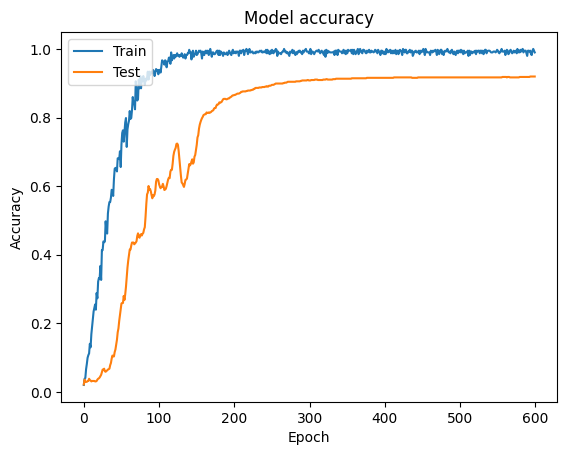

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_130_test1.png")
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# DD_Net.save_weights('weights/coarse_heavy.h1')

In [14]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [15]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [16]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9195402298850575


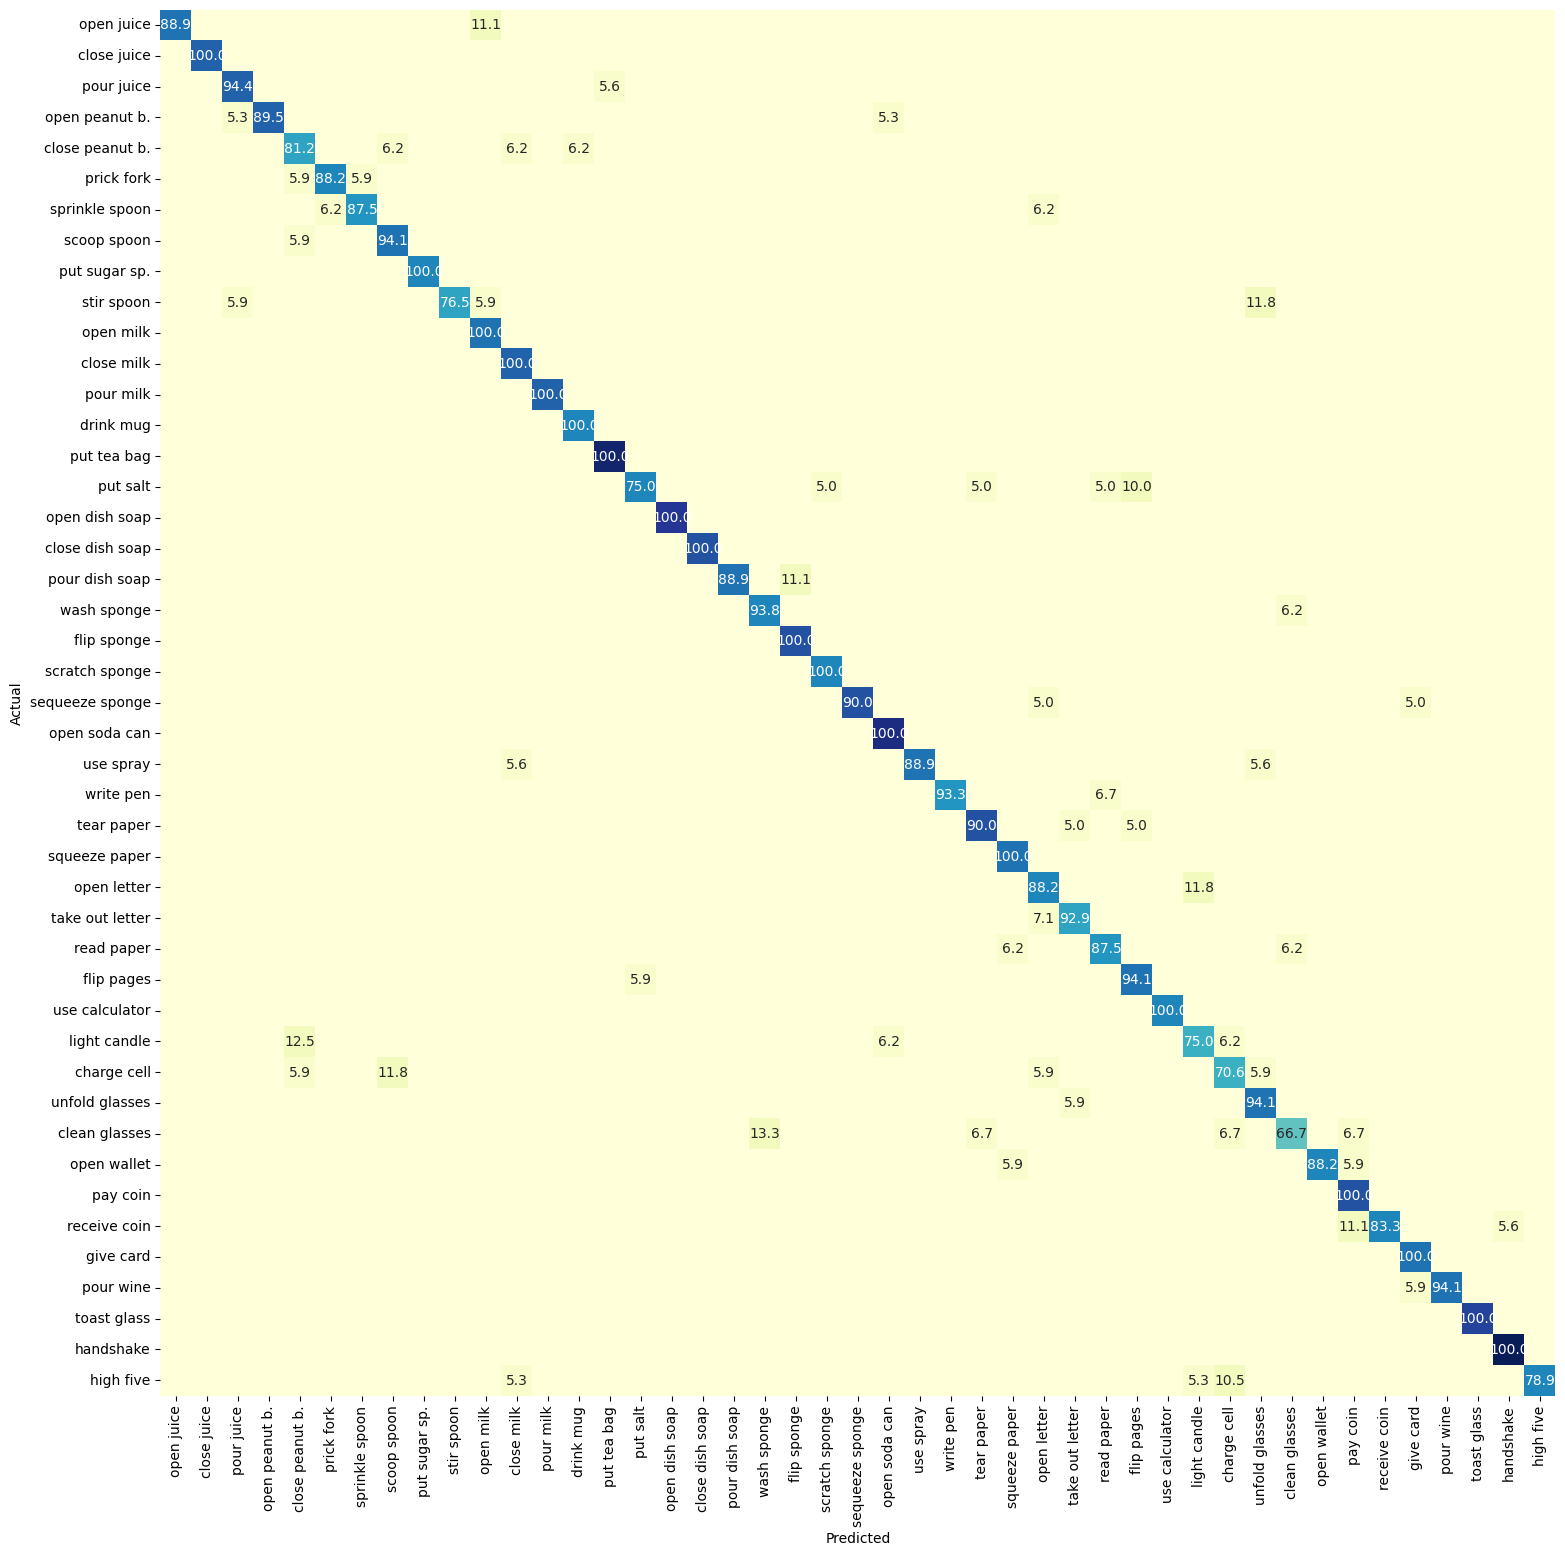

In [17]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test2.png', labels, ymap=None, figsize=(18,18))

## Training with frame_sampling

In [18]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [19]:
epochs = 20  #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,20,3])
        p = sampling_frame(p,C)
       
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net_model = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

epoch0


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 117.52it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 4s 10ms/step - loss: 0.1699 - accuracy: 0.9821 - val_loss: 0.3590 - val_accuracy: 0.9195
epoch1


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 120.17it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 229us/step - loss: 0.1876 - accuracy: 0.9821 - val_loss: 0.3590 - val_accuracy: 0.9195
epoch2


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 119.31it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 251us/step - loss: 0.1807 - accuracy: 0.9847 - val_loss: 0.3592 - val_accuracy: 0.9195
epoch3


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 118.08it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 245us/step - loss: 0.1852 - accuracy: 0.9923 - val_loss: 0.3594 - val_accuracy: 0.9195
epoch4


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 119.91it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 226us/step - loss: 0.1764 - accuracy: 0.9719 - val_loss: 0.3595 - val_accuracy: 0.9195
epoch5


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 119.43it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 240us/step - loss: 0.1631 - accuracy: 0.9898 - val_loss: 0.3594 - val_accuracy: 0.9195
epoch6


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 105.89it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 240us/step - loss: 0.1488 - accuracy: 0.9949 - val_loss: 0.3594 - val_accuracy: 0.9195
epoch7


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 107.26it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 228us/step - loss: 0.1764 - accuracy: 0.9821 - val_loss: 0.3591 - val_accuracy: 0.9195
epoch8


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 107.72it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 229us/step - loss: 0.1463 - accuracy: 0.9872 - val_loss: 0.3590 - val_accuracy: 0.9195
epoch9


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 107.89it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 235us/step - loss: 0.1613 - accuracy: 0.9821 - val_loss: 0.3588 - val_accuracy: 0.9195
epoch10


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 108.73it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 236us/step - loss: 0.1643 - accuracy: 0.9872 - val_loss: 0.3586 - val_accuracy: 0.9195
epoch11


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 110.47it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 229us/step - loss: 0.1541 - accuracy: 0.9923 - val_loss: 0.3585 - val_accuracy: 0.9195
epoch12


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 111.51it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 224us/step - loss: 0.1635 - accuracy: 0.9796 - val_loss: 0.3584 - val_accuracy: 0.9195
epoch13


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 112.23it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 228us/step - loss: 0.1480 - accuracy: 0.9898 - val_loss: 0.3582 - val_accuracy: 0.9195
epoch14


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 110.99it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 225us/step - loss: 0.1371 - accuracy: 0.9949 - val_loss: 0.3580 - val_accuracy: 0.9195
epoch15


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 110.71it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 221us/step - loss: 0.1614 - accuracy: 0.9847 - val_loss: 0.3577 - val_accuracy: 0.9195
epoch16


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 109.54it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 226us/step - loss: 0.1684 - accuracy: 0.9821 - val_loss: 0.3575 - val_accuracy: 0.9195
epoch17


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 108.62it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 220us/step - loss: 0.1608 - accuracy: 0.9898 - val_loss: 0.3574 - val_accuracy: 0.9195
epoch18


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 110.36it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 220us/step - loss: 0.1516 - accuracy: 0.9949 - val_loss: 0.3573 - val_accuracy: 0.9195
epoch19


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 110.84it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 226us/step - loss: 0.1640 - accuracy: 0.9847 - val_loss: 0.3572 - val_accuracy: 0.9195


# Plotting confusion matrix

In [20]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [21]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [22]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9195402298850575


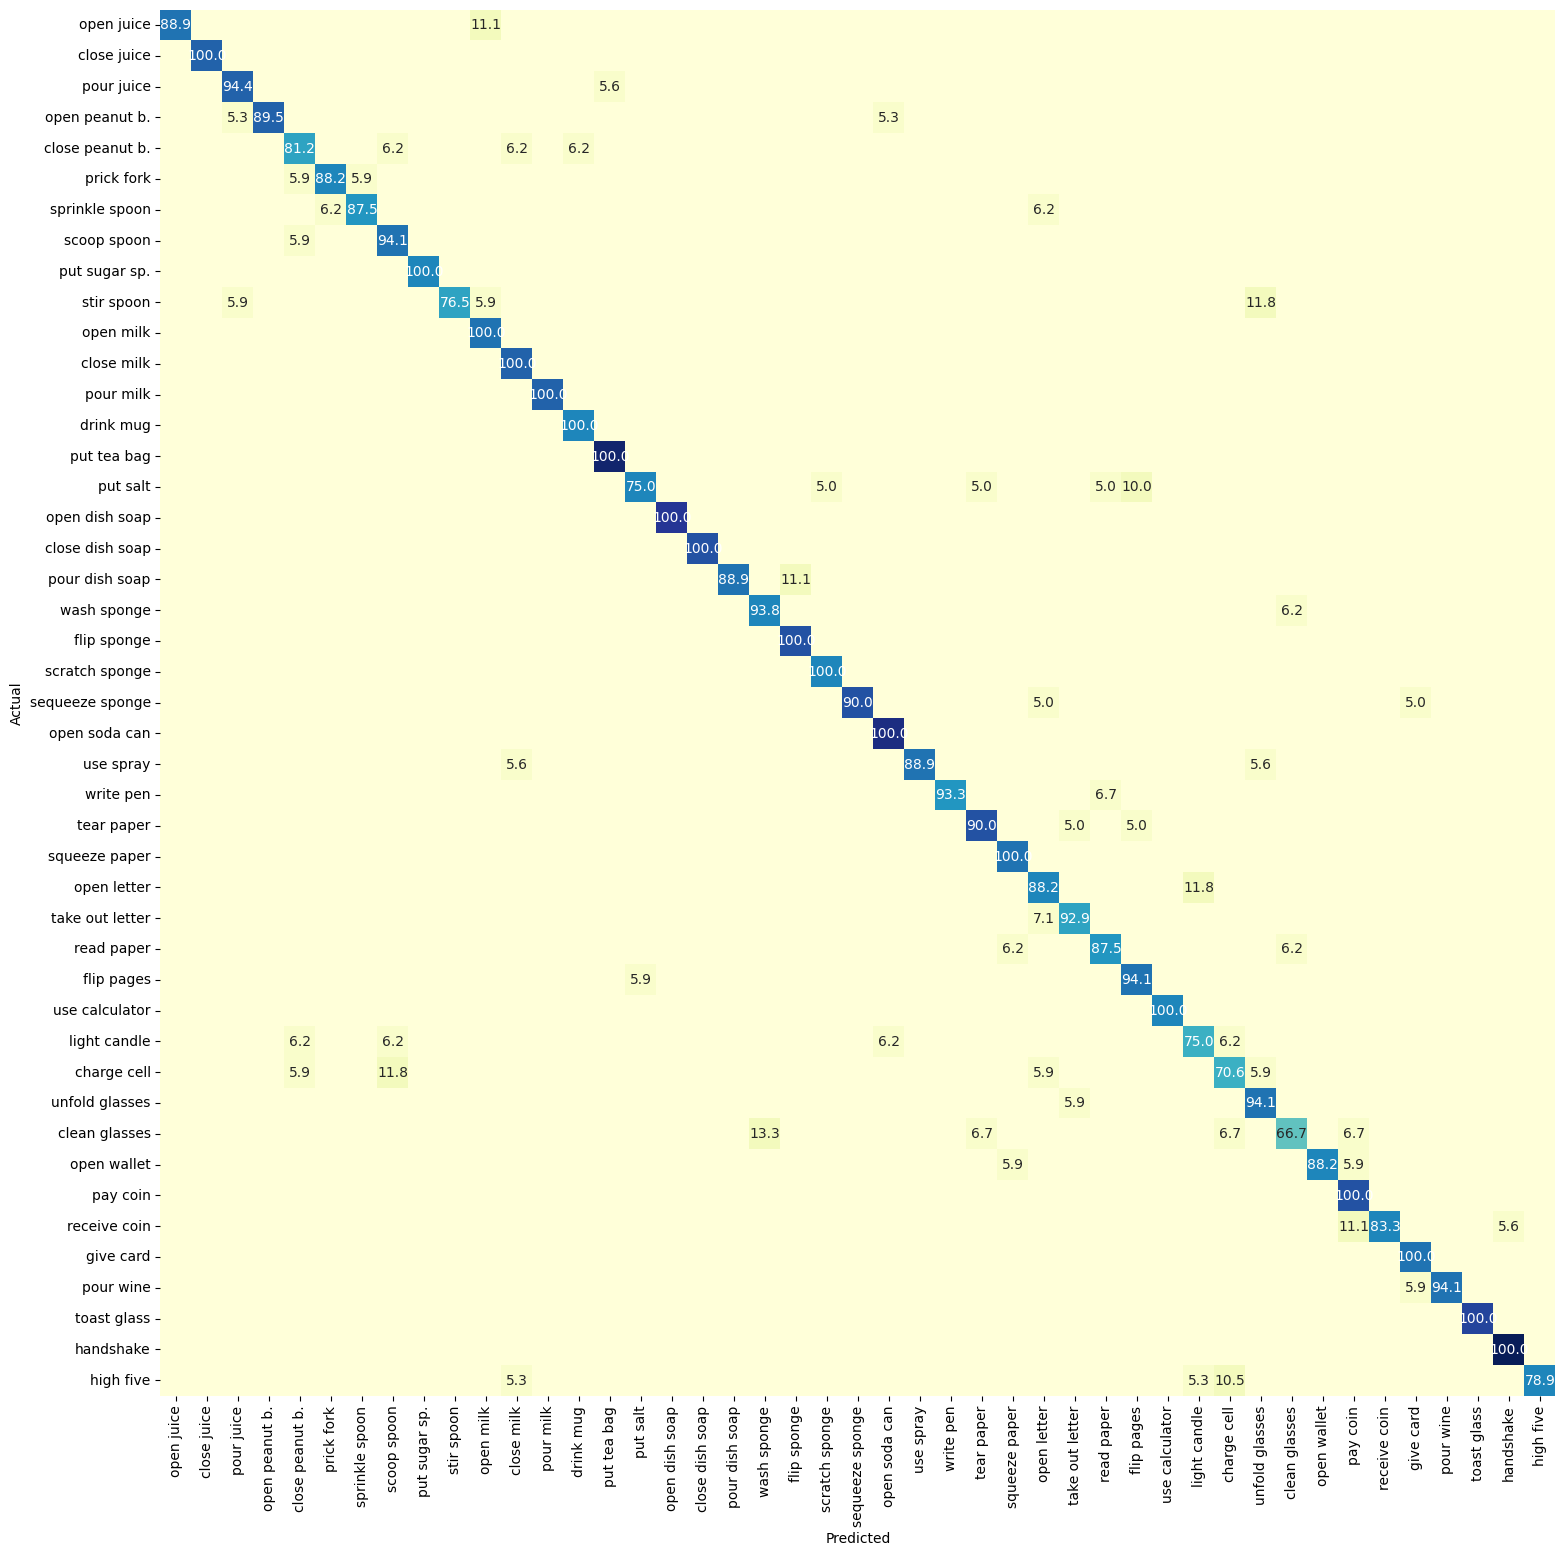

In [23]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test3.png', labels, ymap=None, figsize=(18,18))

# Policy gradient for frame selection  -------train

In [24]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

gamma = 0.7


class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions 

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) 

        self.linear_layers = Sequential(
            Linear(7680,3)) #32 8448  #7680
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) 
        log_pr = torch.log(pr.squeeze(0)[act]) 
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r    
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class): 
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 5 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = (np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1])) ## -1 is bcz classes are from 1 to 10

  return reward   

def train(oridata,labels): 
    n_states=32 
    n_actions=3 
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) 
    max_episode_num =  1
    max_steps = 32  
    all_rewards = []
    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []
            rng = default_rng()
            Action=[]
            if len(oridata[v])>=32:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v]  
            original_fr=XX.clone().detach()  
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):
                state = original_fr[MM[steps]]
                state = state.reshape(1, 1, 20, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1
                q = np.array(xm1)
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

                M = get_CG(q,C)  
                q = q.reshape(1,32,20,3)
                M = M.reshape(1,32,190)

                original_fr = XX
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1    
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob 
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)
        x_tr = torch.stack(x_tr)

        if episode==max_episode_num-1:
          final_ind.append(Action)
            

        
        R=np.sum((rewards2))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
Train = pickle.load(open(C.data_dir+"train_130.pkl","rb"))

oridata = []

for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,20,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    
labels = [int(Train['label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
labels_original = labels

100%|██████████████████████████████████████| 392/392 [00:00<00:00, 28733.63it/s]


### epoch 1

In [26]:
all_rewards,x_trnew,policy_net=train(oridata,labels_original)

 24%|██████████▏                               | 95/392 [01:08<03:28,  1.42it/s]


 49%|████████████████████                     | 192/392 [02:14<02:17,  1.46it/s]


 74%|██████████████████████████████▏          | 289/392 [03:19<01:11,  1.45it/s]


 98%|████████████████████████████████████████▎| 386/392 [04:24<00:04,  1.49it/s]


100%|████████████████████████████████████████████| 1/1 [04:28<00:00, 268.69s/it]


[-6.46875]


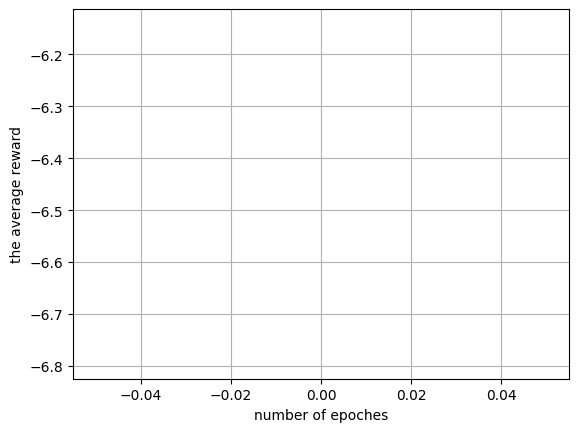

In [27]:
print(all_rewards)
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_130_test4_reward.png")
plt.grid()

In [28]:
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|████████████████████████████████████████| 392/392 [00:03<00:00, 127.50it/s]


In [29]:
# it may takes several times to reach the reported performance
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 4s 10ms/step - loss: 0.2930 - accuracy: 0.9515 - val_loss: 0.4841 - val_accuracy: 0.8723
Epoch 2/600
392/392 [==============================] - 0s 218us/step - loss: 0.2349 - accuracy: 0.9796 - val_loss: 0.4854 - val_accuracy: 0.8761
Epoch 3/600
392/392 [==============================] - 0s 220us/step - loss: 0.2953 - accuracy: 0.9566 - val_loss: 0.5378 - val_accuracy: 0.8633
Epoch 4/600
392/392 [==============================] - 0s 229us/step - loss: 0.3559 - accuracy: 0.9235 - val_loss: 0.5849 - val_accuracy: 0.8429
Epoch 5/600
392/392 [==============================] - 0s 215us/step - loss: 0.2863 - accuracy: 0.9566 - val_loss: 0.7475 - val_accuracy: 0.7944
Epoch 6/600
392/392 [==============================] - 0s 222us/step - loss: 0.2482 - accuracy: 0.9745 - val_loss: 0.9058 - val_accuracy: 0.7625
Epoch 7/600
392/392 [==============================] - 0s 220us/step - loss: 0.2826 -

Epoch 57/600
392/392 [==============================] - 0s 235us/step - loss: 0.1112 - accuracy: 0.9872 - val_loss: 0.5203 - val_accuracy: 0.8595
Epoch 58/600
392/392 [==============================] - 0s 237us/step - loss: 0.1299 - accuracy: 0.9847 - val_loss: 0.5028 - val_accuracy: 0.8659
Epoch 59/600
392/392 [==============================] - 0s 238us/step - loss: 0.1152 - accuracy: 0.9872 - val_loss: 0.4864 - val_accuracy: 0.8697
Epoch 60/600
392/392 [==============================] - 0s 250us/step - loss: 0.1008 - accuracy: 0.9949 - val_loss: 0.4741 - val_accuracy: 0.8736
Epoch 61/600
392/392 [==============================] - 0s 240us/step - loss: 0.1053 - accuracy: 0.9872 - val_loss: 0.4674 - val_accuracy: 0.8736
Epoch 62/600
392/392 [==============================] - 0s 240us/step - loss: 0.1003 - accuracy: 0.9974 - val_loss: 0.4623 - val_accuracy: 0.8761
Epoch 63/600
392/392 [==============================] - 0s 238us/step - loss: 0.1038 - accuracy: 0.9872 - val_loss: 0.4587 -

392/392 [==============================] - 0s 238us/step - loss: 0.0850 - accuracy: 0.9949 - val_loss: 0.3563 - val_accuracy: 0.9132
Epoch 114/600
392/392 [==============================] - 0s 240us/step - loss: 0.1061 - accuracy: 0.9923 - val_loss: 0.3554 - val_accuracy: 0.9132
Epoch 115/600
392/392 [==============================] - 0s 232us/step - loss: 0.1062 - accuracy: 0.9872 - val_loss: 0.3546 - val_accuracy: 0.9132
Epoch 116/600
392/392 [==============================] - 0s 246us/step - loss: 0.0948 - accuracy: 0.9949 - val_loss: 0.3537 - val_accuracy: 0.9144
Epoch 117/600
392/392 [==============================] - 0s 260us/step - loss: 0.0988 - accuracy: 0.9949 - val_loss: 0.3529 - val_accuracy: 0.9144
Epoch 118/600
392/392 [==============================] - 0s 265us/step - loss: 0.0956 - accuracy: 0.9949 - val_loss: 0.3521 - val_accuracy: 0.9157
Epoch 119/600
392/392 [==============================] - 0s 236us/step - loss: 0.1045 - accuracy: 0.9949 - val_loss: 0.3514 - val_ac

Epoch 169/600
392/392 [==============================] - 0s 235us/step - loss: 0.0869 - accuracy: 0.9949 - val_loss: 0.3307 - val_accuracy: 0.9183
Epoch 170/600
392/392 [==============================] - 0s 241us/step - loss: 0.0836 - accuracy: 0.9974 - val_loss: 0.3305 - val_accuracy: 0.9195
Epoch 171/600
392/392 [==============================] - 0s 240us/step - loss: 0.0908 - accuracy: 0.9949 - val_loss: 0.3303 - val_accuracy: 0.9195
Epoch 172/600
392/392 [==============================] - 0s 242us/step - loss: 0.1100 - accuracy: 0.9872 - val_loss: 0.3302 - val_accuracy: 0.9195
Epoch 173/600
392/392 [==============================] - 0s 273us/step - loss: 0.0897 - accuracy: 0.9974 - val_loss: 0.3300 - val_accuracy: 0.9208
Epoch 174/600
392/392 [==============================] - 0s 239us/step - loss: 0.0948 - accuracy: 0.9949 - val_loss: 0.3299 - val_accuracy: 0.9208
Epoch 175/600
392/392 [==============================] - 0s 238us/step - loss: 0.0787 - accuracy: 0.9949 - val_loss: 0

Epoch 225/600
392/392 [==============================] - 0s 234us/step - loss: 0.0878 - accuracy: 0.9974 - val_loss: 0.3223 - val_accuracy: 0.9208
Epoch 226/600
392/392 [==============================] - 0s 243us/step - loss: 0.0942 - accuracy: 0.9949 - val_loss: 0.3222 - val_accuracy: 0.9208
Epoch 227/600
392/392 [==============================] - 0s 238us/step - loss: 0.0964 - accuracy: 0.9898 - val_loss: 0.3221 - val_accuracy: 0.9208
Epoch 228/600
392/392 [==============================] - 0s 235us/step - loss: 0.0978 - accuracy: 0.9974 - val_loss: 0.3221 - val_accuracy: 0.9208
Epoch 229/600
392/392 [==============================] - 0s 231us/step - loss: 0.0956 - accuracy: 0.9923 - val_loss: 0.3221 - val_accuracy: 0.9208
Epoch 230/600
392/392 [==============================] - 0s 236us/step - loss: 0.0918 - accuracy: 0.9898 - val_loss: 0.3220 - val_accuracy: 0.9221
Epoch 231/600
392/392 [==============================] - 0s 241us/step - loss: 0.1012 - accuracy: 0.9974 - val_loss: 0

Epoch 281/600
392/392 [==============================] - 0s 242us/step - loss: 0.0986 - accuracy: 0.9974 - val_loss: 0.3199 - val_accuracy: 0.9246
Epoch 282/600
392/392 [==============================] - 0s 256us/step - loss: 0.1028 - accuracy: 0.9949 - val_loss: 0.3199 - val_accuracy: 0.9246
Epoch 283/600
392/392 [==============================] - 0s 234us/step - loss: 0.0895 - accuracy: 0.9898 - val_loss: 0.3198 - val_accuracy: 0.9246
Epoch 284/600
392/392 [==============================] - 0s 238us/step - loss: 0.0858 - accuracy: 1.0000 - val_loss: 0.3198 - val_accuracy: 0.9246
Epoch 285/600
392/392 [==============================] - 0s 232us/step - loss: 0.0829 - accuracy: 1.0000 - val_loss: 0.3198 - val_accuracy: 0.9246
Epoch 286/600
392/392 [==============================] - 0s 263us/step - loss: 0.0981 - accuracy: 0.9974 - val_loss: 0.3197 - val_accuracy: 0.9246
Epoch 287/600
392/392 [==============================] - 0s 231us/step - loss: 0.0796 - accuracy: 0.9949 - val_loss: 0

Epoch 337/600
392/392 [==============================] - 0s 237us/step - loss: 0.0874 - accuracy: 0.9949 - val_loss: 0.3193 - val_accuracy: 0.9259
Epoch 338/600
392/392 [==============================] - 0s 244us/step - loss: 0.0895 - accuracy: 0.9949 - val_loss: 0.3193 - val_accuracy: 0.9259
Epoch 339/600
392/392 [==============================] - 0s 258us/step - loss: 0.0825 - accuracy: 1.0000 - val_loss: 0.3193 - val_accuracy: 0.9259
Epoch 340/600
392/392 [==============================] - 0s 237us/step - loss: 0.1012 - accuracy: 0.9949 - val_loss: 0.3193 - val_accuracy: 0.9259
Epoch 341/600
392/392 [==============================] - 0s 238us/step - loss: 0.1008 - accuracy: 0.9898 - val_loss: 0.3194 - val_accuracy: 0.9259
Epoch 342/600
392/392 [==============================] - 0s 240us/step - loss: 0.1098 - accuracy: 0.9923 - val_loss: 0.3195 - val_accuracy: 0.9259
Epoch 343/600
392/392 [==============================] - 0s 234us/step - loss: 0.0854 - accuracy: 0.9974 - val_loss: 0

Epoch 393/600
392/392 [==============================] - 0s 243us/step - loss: 0.0921 - accuracy: 0.9974 - val_loss: 0.3195 - val_accuracy: 0.9259
Epoch 394/600
392/392 [==============================] - 0s 242us/step - loss: 0.0995 - accuracy: 0.9974 - val_loss: 0.3195 - val_accuracy: 0.9259
Epoch 395/600
392/392 [==============================] - 0s 236us/step - loss: 0.1038 - accuracy: 0.9872 - val_loss: 0.3195 - val_accuracy: 0.9259
Epoch 396/600
392/392 [==============================] - 0s 238us/step - loss: 0.0877 - accuracy: 1.0000 - val_loss: 0.3195 - val_accuracy: 0.9259
Epoch 397/600
392/392 [==============================] - 0s 243us/step - loss: 0.0909 - accuracy: 0.9923 - val_loss: 0.3195 - val_accuracy: 0.9259
Epoch 398/600
392/392 [==============================] - 0s 275us/step - loss: 0.0896 - accuracy: 0.9923 - val_loss: 0.3194 - val_accuracy: 0.9259
Epoch 399/600
392/392 [==============================] - 0s 258us/step - loss: 0.0775 - accuracy: 0.9974 - val_loss: 0

Epoch 449/600
392/392 [==============================] - 0s 250us/step - loss: 0.0823 - accuracy: 1.0000 - val_loss: 0.3193 - val_accuracy: 0.9259
Epoch 450/600
392/392 [==============================] - 0s 275us/step - loss: 0.0819 - accuracy: 0.9923 - val_loss: 0.3194 - val_accuracy: 0.9259
Epoch 451/600
392/392 [==============================] - 0s 255us/step - loss: 0.0928 - accuracy: 0.9898 - val_loss: 0.3194 - val_accuracy: 0.9259
Epoch 452/600
392/392 [==============================] - 0s 248us/step - loss: 0.0802 - accuracy: 0.9974 - val_loss: 0.3195 - val_accuracy: 0.9259
Epoch 453/600
392/392 [==============================] - 0s 259us/step - loss: 0.0923 - accuracy: 0.9898 - val_loss: 0.3195 - val_accuracy: 0.9259
Epoch 454/600
392/392 [==============================] - 0s 260us/step - loss: 0.0951 - accuracy: 0.9974 - val_loss: 0.3196 - val_accuracy: 0.9246
Epoch 455/600
392/392 [==============================] - 0s 232us/step - loss: 0.0881 - accuracy: 0.9949 - val_loss: 0

Epoch 505/600
392/392 [==============================] - 0s 234us/step - loss: 0.0833 - accuracy: 0.9949 - val_loss: 0.3212 - val_accuracy: 0.9246
Epoch 506/600
392/392 [==============================] - 0s 235us/step - loss: 0.0978 - accuracy: 0.9949 - val_loss: 0.3212 - val_accuracy: 0.9246
Epoch 507/600
392/392 [==============================] - 0s 270us/step - loss: 0.0904 - accuracy: 0.9974 - val_loss: 0.3212 - val_accuracy: 0.9246
Epoch 508/600
392/392 [==============================] - 0s 241us/step - loss: 0.0769 - accuracy: 0.9974 - val_loss: 0.3212 - val_accuracy: 0.9246
Epoch 509/600
392/392 [==============================] - 0s 249us/step - loss: 0.0758 - accuracy: 0.9974 - val_loss: 0.3212 - val_accuracy: 0.9246
Epoch 510/600
392/392 [==============================] - 0s 256us/step - loss: 0.0978 - accuracy: 0.9949 - val_loss: 0.3212 - val_accuracy: 0.9246
Epoch 511/600
392/392 [==============================] - 0s 251us/step - loss: 0.0790 - accuracy: 0.9923 - val_loss: 0

Epoch 561/600
392/392 [==============================] - 0s 235us/step - loss: 0.0730 - accuracy: 0.9923 - val_loss: 0.3195 - val_accuracy: 0.9246
Epoch 562/600
392/392 [==============================] - 0s 241us/step - loss: 0.0925 - accuracy: 0.9949 - val_loss: 0.3195 - val_accuracy: 0.9246
Epoch 563/600
392/392 [==============================] - 0s 242us/step - loss: 0.0841 - accuracy: 0.9898 - val_loss: 0.3194 - val_accuracy: 0.9246
Epoch 564/600
392/392 [==============================] - 0s 237us/step - loss: 0.0968 - accuracy: 0.9898 - val_loss: 0.3193 - val_accuracy: 0.9246
Epoch 565/600
392/392 [==============================] - 0s 255us/step - loss: 0.0855 - accuracy: 0.9974 - val_loss: 0.3193 - val_accuracy: 0.9246
Epoch 566/600
392/392 [==============================] - 0s 254us/step - loss: 0.0814 - accuracy: 1.0000 - val_loss: 0.3193 - val_accuracy: 0.9246
Epoch 567/600
392/392 [==============================] - 0s 240us/step - loss: 0.0886 - accuracy: 1.0000 - val_loss: 0

In [30]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [31]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [32]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9246487867177522


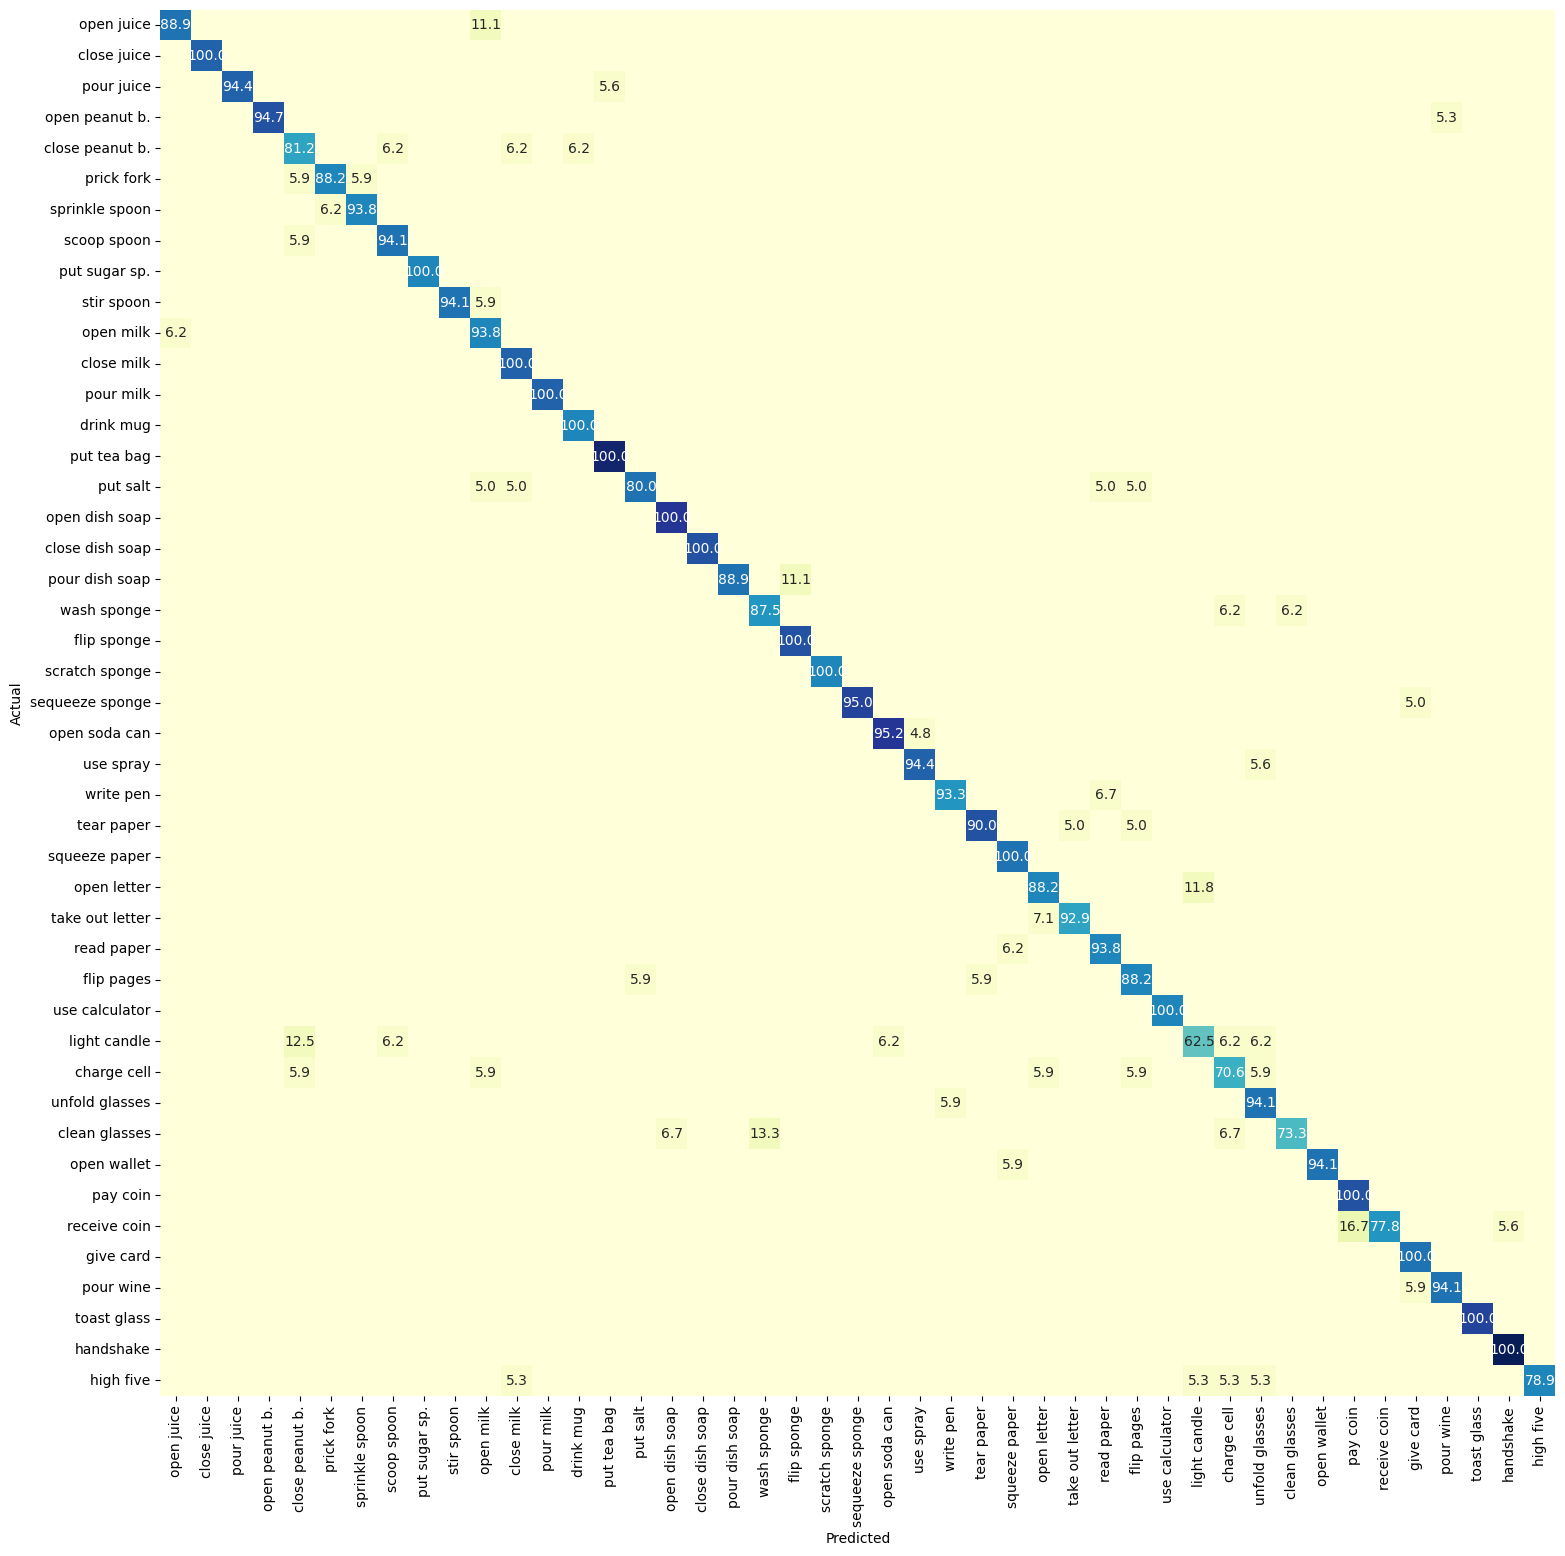

In [33]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test5.png', labels, ymap=None, figsize=(18,18))

### epoch 2 

In [34]:
all_rewards,x_trnew_2,policy_net=train(x_trnew,labels_original)

 24%|██████████▏                               | 95/392 [01:06<03:35,  1.38it/s]


 49%|████████████████████                     | 192/392 [02:13<02:15,  1.48it/s]


 74%|██████████████████████████████▏          | 289/392 [03:21<01:15,  1.37it/s]


 98%|████████████████████████████████████████▎| 386/392 [04:29<00:04,  1.43it/s]


100%|████████████████████████████████████████████| 1/1 [04:33<00:00, 273.18s/it]


[-12.25]


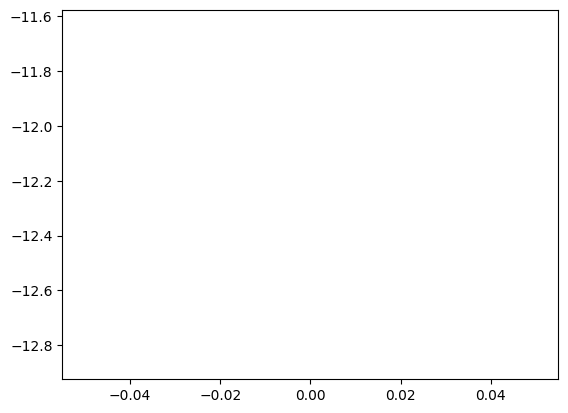

In [35]:
print(all_rewards)
plt.plot(all_rewards)
#plt.xlabel('number of epoches')
#plt.ylabel('the average reward')
#plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLNNet_130_test6_reward.png")
#plt.grid()

In [36]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew_2))):
    w_p = np.copy(x_trnew_2[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|████████████████████████████████████████| 392/392 [00:03<00:00, 130.29it/s]


In [37]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 4s 10ms/step - loss: 0.0917 - accuracy: 0.9923 - val_loss: 0.6850 - val_accuracy: 0.8250
Epoch 2/600
392/392 [==============================] - 0s 233us/step - loss: 0.1370 - accuracy: 0.9923 - val_loss: 0.8243 - val_accuracy: 0.7905
Epoch 3/600
392/392 [==============================] - 0s 219us/step - loss: 0.1173 - accuracy: 0.9949 - val_loss: 1.1903 - val_accuracy: 0.7229
Epoch 4/600
392/392 [==============================] - 0s 265us/step - loss: 0.1318 - accuracy: 0.9898 - val_loss: 1.1680 - val_accuracy: 0.7267
Epoch 5/600
392/392 [==============================] - 0s 231us/step - loss: 0.1317 - accuracy: 0.9872 - val_loss: 0.8492 - val_accuracy: 0.7752
Epoch 6/600
392/392 [==============================] - 0s 226us/step - loss: 0.1288 - accuracy: 0.9872 - val_loss: 0.6905 - val_accuracy: 0.8174
Epoch 7/600
392/392 [==============================] - 0s 213us/step - loss: 0.1360 -

Epoch 57/600
392/392 [==============================] - 0s 244us/step - loss: 0.0690 - accuracy: 0.9949 - val_loss: 0.3878 - val_accuracy: 0.9068
Epoch 58/600
392/392 [==============================] - 0s 247us/step - loss: 0.0809 - accuracy: 0.9949 - val_loss: 0.3870 - val_accuracy: 0.9080
Epoch 59/600
392/392 [==============================] - 0s 245us/step - loss: 0.0596 - accuracy: 1.0000 - val_loss: 0.3865 - val_accuracy: 0.9093
Epoch 60/600
392/392 [==============================] - 0s 265us/step - loss: 0.0741 - accuracy: 0.9898 - val_loss: 0.3860 - val_accuracy: 0.9106
Epoch 61/600
392/392 [==============================] - 0s 242us/step - loss: 0.0690 - accuracy: 0.9974 - val_loss: 0.3861 - val_accuracy: 0.9106
Epoch 62/600
392/392 [==============================] - 0s 238us/step - loss: 0.0664 - accuracy: 0.9949 - val_loss: 0.3862 - val_accuracy: 0.9093
Epoch 63/600
392/392 [==============================] - 0s 237us/step - loss: 0.0644 - accuracy: 0.9974 - val_loss: 0.3862 -

392/392 [==============================] - 0s 262us/step - loss: 0.0669 - accuracy: 0.9923 - val_loss: 0.3567 - val_accuracy: 0.9144
Epoch 114/600
392/392 [==============================] - 0s 266us/step - loss: 0.0671 - accuracy: 0.9974 - val_loss: 0.3562 - val_accuracy: 0.9132
Epoch 115/600
392/392 [==============================] - 0s 254us/step - loss: 0.0656 - accuracy: 0.9949 - val_loss: 0.3558 - val_accuracy: 0.9132
Epoch 116/600
392/392 [==============================] - 0s 274us/step - loss: 0.0600 - accuracy: 0.9974 - val_loss: 0.3553 - val_accuracy: 0.9132
Epoch 117/600
392/392 [==============================] - 0s 250us/step - loss: 0.0598 - accuracy: 1.0000 - val_loss: 0.3549 - val_accuracy: 0.9132
Epoch 118/600
392/392 [==============================] - 0s 242us/step - loss: 0.0604 - accuracy: 0.9923 - val_loss: 0.3544 - val_accuracy: 0.9132
Epoch 119/600
392/392 [==============================] - 0s 275us/step - loss: 0.0576 - accuracy: 0.9949 - val_loss: 0.3540 - val_ac

Epoch 169/600
392/392 [==============================] - 0s 246us/step - loss: 0.0661 - accuracy: 1.0000 - val_loss: 0.3392 - val_accuracy: 0.9144
Epoch 170/600
392/392 [==============================] - 0s 245us/step - loss: 0.0648 - accuracy: 0.9923 - val_loss: 0.3390 - val_accuracy: 0.9144
Epoch 171/600
392/392 [==============================] - 0s 240us/step - loss: 0.0732 - accuracy: 0.9898 - val_loss: 0.3387 - val_accuracy: 0.9144
Epoch 172/600
392/392 [==============================] - 0s 245us/step - loss: 0.0737 - accuracy: 0.9898 - val_loss: 0.3385 - val_accuracy: 0.9144
Epoch 173/600
392/392 [==============================] - 0s 242us/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 0.3382 - val_accuracy: 0.9157
Epoch 174/600
392/392 [==============================] - 0s 245us/step - loss: 0.0734 - accuracy: 0.9923 - val_loss: 0.3381 - val_accuracy: 0.9157
Epoch 175/600
392/392 [==============================] - 0s 244us/step - loss: 0.0709 - accuracy: 0.9974 - val_loss: 0

Epoch 225/600
392/392 [==============================] - 0s 247us/step - loss: 0.0659 - accuracy: 0.9949 - val_loss: 0.3317 - val_accuracy: 0.9170
Epoch 226/600
392/392 [==============================] - 0s 246us/step - loss: 0.0590 - accuracy: 1.0000 - val_loss: 0.3316 - val_accuracy: 0.9170
Epoch 227/600
392/392 [==============================] - 0s 250us/step - loss: 0.0729 - accuracy: 0.9923 - val_loss: 0.3315 - val_accuracy: 0.9170
Epoch 228/600
392/392 [==============================] - 0s 242us/step - loss: 0.0676 - accuracy: 0.9974 - val_loss: 0.3313 - val_accuracy: 0.9170
Epoch 229/600
392/392 [==============================] - 0s 258us/step - loss: 0.0645 - accuracy: 0.9923 - val_loss: 0.3312 - val_accuracy: 0.9170
Epoch 230/600
392/392 [==============================] - 0s 267us/step - loss: 0.0651 - accuracy: 0.9974 - val_loss: 0.3312 - val_accuracy: 0.9170
Epoch 231/600
392/392 [==============================] - 0s 255us/step - loss: 0.0571 - accuracy: 0.9974 - val_loss: 0

Epoch 281/600
392/392 [==============================] - 0s 256us/step - loss: 0.0644 - accuracy: 0.9974 - val_loss: 0.3286 - val_accuracy: 0.9195
Epoch 282/600
392/392 [==============================] - 0s 285us/step - loss: 0.0633 - accuracy: 1.0000 - val_loss: 0.3286 - val_accuracy: 0.9195
Epoch 283/600
392/392 [==============================] - 0s 248us/step - loss: 0.0638 - accuracy: 0.9974 - val_loss: 0.3285 - val_accuracy: 0.9195
Epoch 284/600
392/392 [==============================] - 0s 264us/step - loss: 0.0499 - accuracy: 0.9949 - val_loss: 0.3284 - val_accuracy: 0.9195
Epoch 285/600
392/392 [==============================] - 0s 274us/step - loss: 0.0741 - accuracy: 0.9923 - val_loss: 0.3284 - val_accuracy: 0.9195
Epoch 286/600
392/392 [==============================] - 0s 245us/step - loss: 0.0726 - accuracy: 0.9974 - val_loss: 0.3283 - val_accuracy: 0.9195
Epoch 287/600
392/392 [==============================] - 0s 247us/step - loss: 0.0609 - accuracy: 0.9974 - val_loss: 0

Epoch 337/600
392/392 [==============================] - 0s 252us/step - loss: 0.0522 - accuracy: 0.9974 - val_loss: 0.3258 - val_accuracy: 0.9221
Epoch 338/600
392/392 [==============================] - 0s 243us/step - loss: 0.0553 - accuracy: 0.9974 - val_loss: 0.3258 - val_accuracy: 0.9221
Epoch 339/600
392/392 [==============================] - 0s 248us/step - loss: 0.0488 - accuracy: 0.9974 - val_loss: 0.3258 - val_accuracy: 0.9221
Epoch 340/600
392/392 [==============================] - 0s 297us/step - loss: 0.0605 - accuracy: 0.9949 - val_loss: 0.3257 - val_accuracy: 0.9221
Epoch 341/600
392/392 [==============================] - 0s 270us/step - loss: 0.0665 - accuracy: 0.9923 - val_loss: 0.3257 - val_accuracy: 0.9221
Epoch 342/600
392/392 [==============================] - 0s 274us/step - loss: 0.0592 - accuracy: 0.9949 - val_loss: 0.3257 - val_accuracy: 0.9221
Epoch 343/600
392/392 [==============================] - 0s 272us/step - loss: 0.0639 - accuracy: 0.9974 - val_loss: 0

Epoch 393/600
392/392 [==============================] - 0s 259us/step - loss: 0.0533 - accuracy: 0.9974 - val_loss: 0.3260 - val_accuracy: 0.9234
Epoch 394/600
392/392 [==============================] - 0s 251us/step - loss: 0.0649 - accuracy: 0.9949 - val_loss: 0.3260 - val_accuracy: 0.9234
Epoch 395/600
392/392 [==============================] - 0s 243us/step - loss: 0.0659 - accuracy: 0.9949 - val_loss: 0.3259 - val_accuracy: 0.9234
Epoch 396/600
392/392 [==============================] - 0s 239us/step - loss: 0.0603 - accuracy: 0.9949 - val_loss: 0.3259 - val_accuracy: 0.9234
Epoch 397/600
392/392 [==============================] - 0s 248us/step - loss: 0.0548 - accuracy: 1.0000 - val_loss: 0.3259 - val_accuracy: 0.9234
Epoch 398/600
392/392 [==============================] - 0s 259us/step - loss: 0.0578 - accuracy: 0.9974 - val_loss: 0.3259 - val_accuracy: 0.9234
Epoch 399/600
392/392 [==============================] - 0s 261us/step - loss: 0.0474 - accuracy: 0.9974 - val_loss: 0

Epoch 449/600
392/392 [==============================] - 0s 258us/step - loss: 0.0562 - accuracy: 0.9974 - val_loss: 0.3238 - val_accuracy: 0.9221
Epoch 450/600
392/392 [==============================] - 0s 251us/step - loss: 0.0596 - accuracy: 0.9949 - val_loss: 0.3238 - val_accuracy: 0.9221
Epoch 451/600
392/392 [==============================] - 0s 274us/step - loss: 0.0503 - accuracy: 1.0000 - val_loss: 0.3238 - val_accuracy: 0.9221
Epoch 452/600
392/392 [==============================] - 0s 253us/step - loss: 0.0551 - accuracy: 0.9974 - val_loss: 0.3238 - val_accuracy: 0.9221
Epoch 453/600
392/392 [==============================] - 0s 306us/step - loss: 0.0543 - accuracy: 0.9949 - val_loss: 0.3238 - val_accuracy: 0.9221
Epoch 454/600
392/392 [==============================] - 0s 275us/step - loss: 0.0588 - accuracy: 0.9923 - val_loss: 0.3238 - val_accuracy: 0.9221
Epoch 455/600
392/392 [==============================] - 0s 249us/step - loss: 0.0517 - accuracy: 1.0000 - val_loss: 0

Epoch 505/600
392/392 [==============================] - 0s 242us/step - loss: 0.0605 - accuracy: 0.9949 - val_loss: 0.3223 - val_accuracy: 0.9234
Epoch 506/600
392/392 [==============================] - 0s 251us/step - loss: 0.0588 - accuracy: 0.9974 - val_loss: 0.3223 - val_accuracy: 0.9234
Epoch 507/600
392/392 [==============================] - 0s 255us/step - loss: 0.0621 - accuracy: 0.9974 - val_loss: 0.3222 - val_accuracy: 0.9234
Epoch 508/600
392/392 [==============================] - 0s 259us/step - loss: 0.0614 - accuracy: 1.0000 - val_loss: 0.3221 - val_accuracy: 0.9234
Epoch 509/600
392/392 [==============================] - 0s 276us/step - loss: 0.0532 - accuracy: 0.9974 - val_loss: 0.3221 - val_accuracy: 0.9234
Epoch 510/600
392/392 [==============================] - 0s 249us/step - loss: 0.0497 - accuracy: 1.0000 - val_loss: 0.3221 - val_accuracy: 0.9234
Epoch 511/600
392/392 [==============================] - 0s 244us/step - loss: 0.0564 - accuracy: 0.9974 - val_loss: 0

Epoch 561/600
392/392 [==============================] - 0s 251us/step - loss: 0.0542 - accuracy: 1.0000 - val_loss: 0.3212 - val_accuracy: 0.9208
Epoch 562/600
392/392 [==============================] - 0s 250us/step - loss: 0.0661 - accuracy: 0.9949 - val_loss: 0.3213 - val_accuracy: 0.9208
Epoch 563/600
392/392 [==============================] - 0s 246us/step - loss: 0.0615 - accuracy: 0.9949 - val_loss: 0.3213 - val_accuracy: 0.9208
Epoch 564/600
392/392 [==============================] - 0s 253us/step - loss: 0.0634 - accuracy: 0.9949 - val_loss: 0.3213 - val_accuracy: 0.9208
Epoch 565/600
392/392 [==============================] - 0s 247us/step - loss: 0.0620 - accuracy: 0.9974 - val_loss: 0.3213 - val_accuracy: 0.9208
Epoch 566/600
392/392 [==============================] - 0s 248us/step - loss: 0.0624 - accuracy: 0.9949 - val_loss: 0.3213 - val_accuracy: 0.9208
Epoch 567/600
392/392 [==============================] - 0s 255us/step - loss: 0.0510 - accuracy: 1.0000 - val_loss: 0

In [38]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9208173690932312


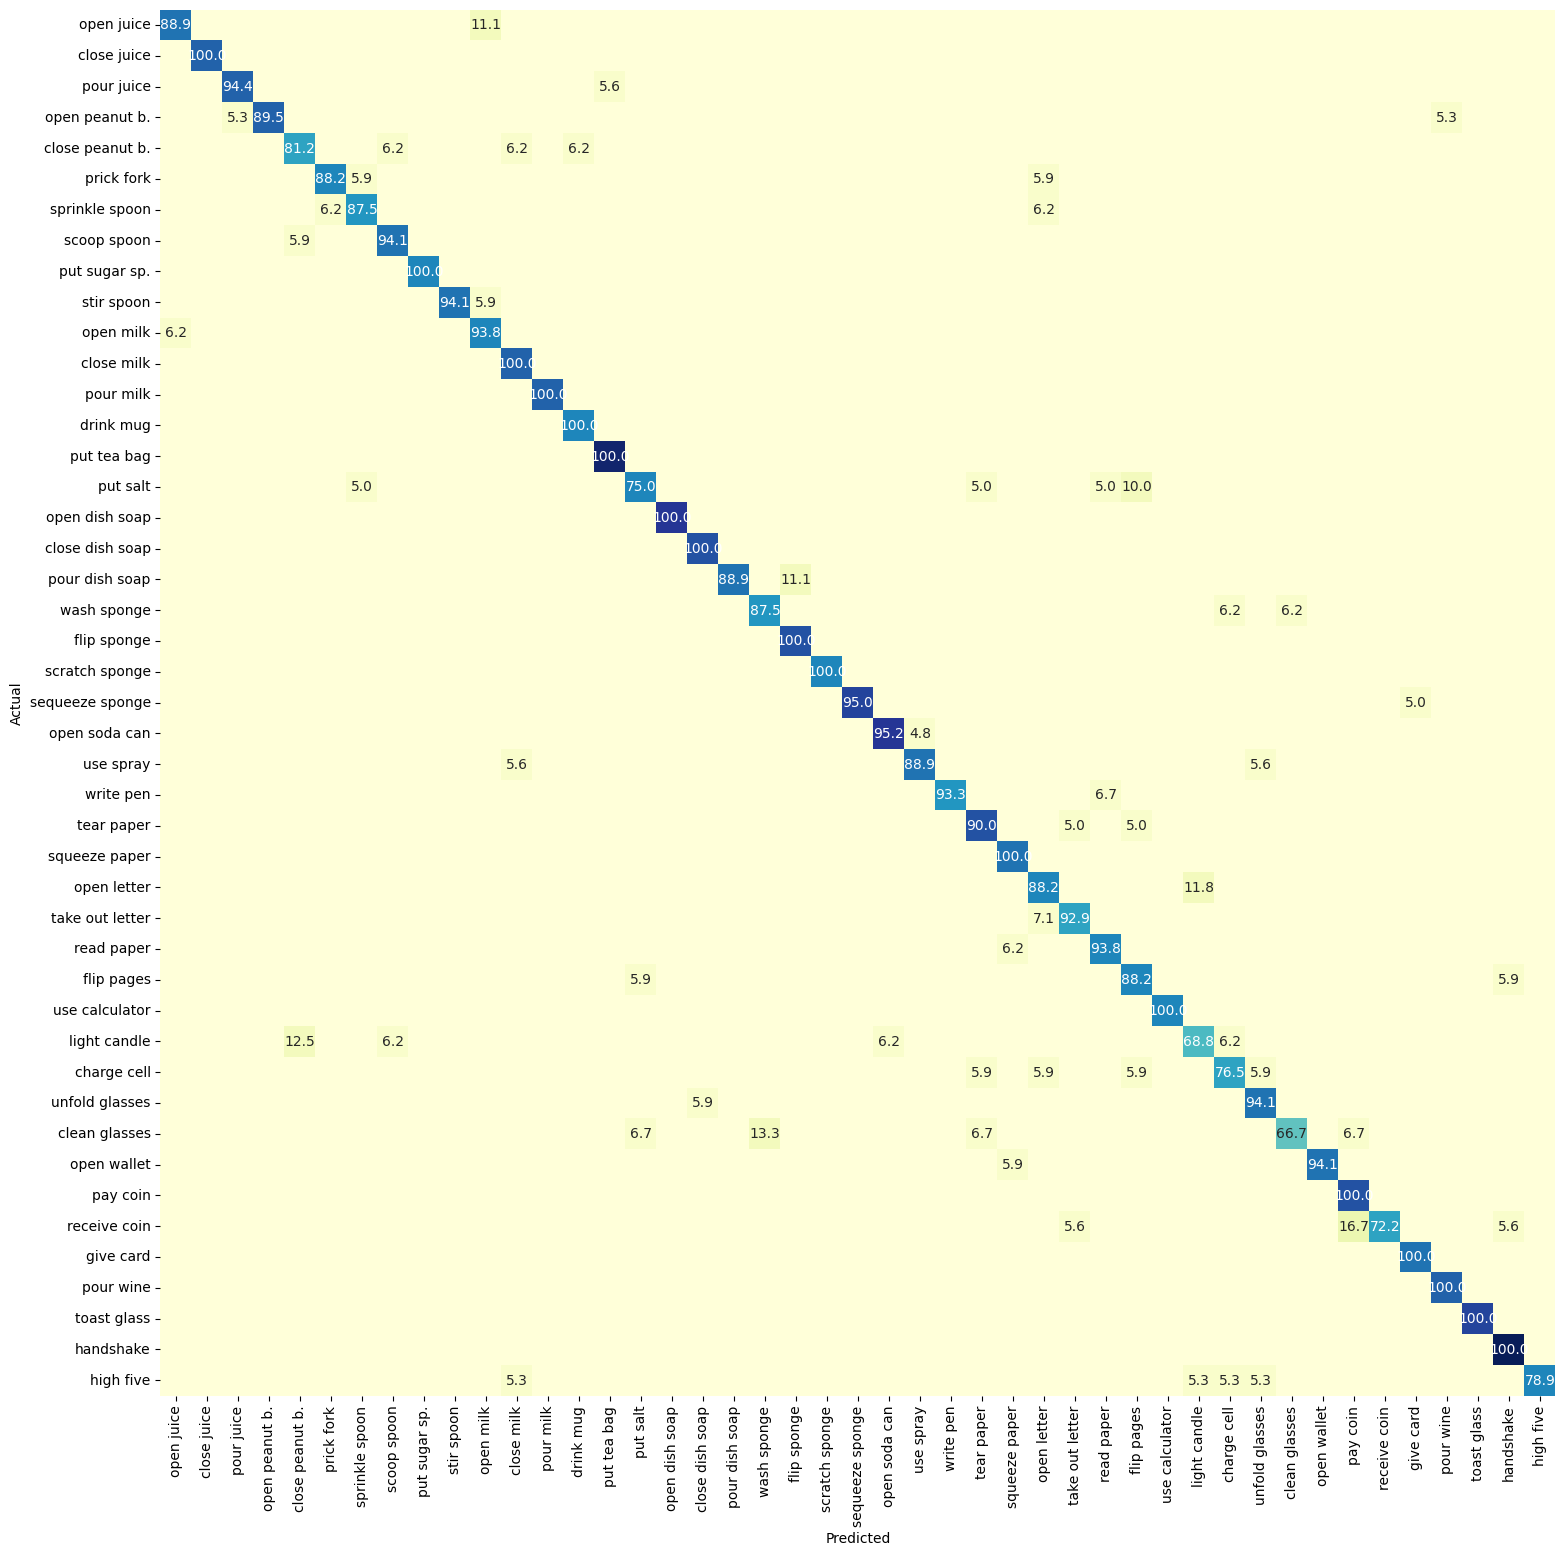

In [39]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test6.png', labels, ymap=None, figsize=(18,18))

### epoch 3 

In [40]:
all_rewards,x_trnew_3,policy_net=train(x_trnew_2,labels_original)
print(all_rewards)
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_3))):
    w_p = np.copy(x_trnew_3[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 24%|██████████▏                               | 95/392 [01:07<03:30,  1.41it/s]


 49%|████████████████████                     | 192/392 [02:18<02:37,  1.27it/s]


 74%|██████████████████████████████▏          | 289/392 [03:32<01:17,  1.32it/s]


 98%|████████████████████████████████████████▎| 386/392 [04:45<00:04,  1.28it/s]


100%|████████████████████████████████████████████| 1/1 [04:50<00:00, 290.57s/it]


[-12.25]


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 114.90it/s]


In [41]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 4s 10ms/step - loss: 0.0534 - accuracy: 1.0000 - val_loss: 0.4527 - val_accuracy: 0.8812
Epoch 2/600
392/392 [==============================] - 0s 235us/step - loss: 0.0842 - accuracy: 0.9847 - val_loss: 0.7004 - val_accuracy: 0.8340
Epoch 3/600
392/392 [==============================] - 0s 242us/step - loss: 0.1073 - accuracy: 0.9923 - val_loss: 0.7985 - val_accuracy: 0.8250
Epoch 4/600
392/392 [==============================] - 0s 231us/step - loss: 0.0858 - accuracy: 0.9872 - val_loss: 0.6202 - val_accuracy: 0.8480
Epoch 5/600
392/392 [==============================] - 0s 244us/step - loss: 0.0978 - accuracy: 0.9872 - val_loss: 0.6363 - val_accuracy: 0.8378
Epoch 6/600
392/392 [==============================] - 0s 234us/step - loss: 0.1042 - accuracy: 0.9847 - val_loss: 0.7816 - val_accuracy: 0.7957
Epoch 7/600
392/392 [==============================] - 0s 259us/step - loss: 0.0935 -

Epoch 57/600
392/392 [==============================] - 0s 267us/step - loss: 0.0562 - accuracy: 0.9974 - val_loss: 0.4314 - val_accuracy: 0.8851
Epoch 58/600
392/392 [==============================] - 0s 273us/step - loss: 0.0649 - accuracy: 0.9923 - val_loss: 0.4287 - val_accuracy: 0.8889
Epoch 59/600
392/392 [==============================] - 0s 250us/step - loss: 0.0423 - accuracy: 1.0000 - val_loss: 0.4258 - val_accuracy: 0.8927
Epoch 60/600
392/392 [==============================] - 0s 249us/step - loss: 0.0595 - accuracy: 0.9949 - val_loss: 0.4235 - val_accuracy: 0.8940
Epoch 61/600
392/392 [==============================] - 0s 242us/step - loss: 0.0528 - accuracy: 0.9974 - val_loss: 0.4211 - val_accuracy: 0.8940
Epoch 62/600
392/392 [==============================] - 0s 255us/step - loss: 0.0553 - accuracy: 0.9949 - val_loss: 0.4186 - val_accuracy: 0.8927
Epoch 63/600
392/392 [==============================] - 0s 243us/step - loss: 0.0499 - accuracy: 0.9974 - val_loss: 0.4165 -

Epoch 114/600
392/392 [==============================] - 0s 247us/step - loss: 0.0547 - accuracy: 0.9974 - val_loss: 0.3575 - val_accuracy: 0.9195
Epoch 115/600
392/392 [==============================] - 0s 253us/step - loss: 0.0408 - accuracy: 1.0000 - val_loss: 0.3569 - val_accuracy: 0.9195
Epoch 116/600
392/392 [==============================] - 0s 239us/step - loss: 0.0425 - accuracy: 0.9974 - val_loss: 0.3563 - val_accuracy: 0.9195
Epoch 117/600
392/392 [==============================] - 0s 260us/step - loss: 0.0393 - accuracy: 0.9974 - val_loss: 0.3558 - val_accuracy: 0.9195
Epoch 118/600
392/392 [==============================] - 0s 239us/step - loss: 0.0669 - accuracy: 0.9949 - val_loss: 0.3553 - val_accuracy: 0.9195
Epoch 119/600
392/392 [==============================] - 0s 244us/step - loss: 0.0500 - accuracy: 1.0000 - val_loss: 0.3548 - val_accuracy: 0.9195
Epoch 120/600
392/392 [==============================] - 0s 239us/step - loss: 0.0427 - accuracy: 1.0000 - val_loss: 0

Epoch 170/600
392/392 [==============================] - 0s 267us/step - loss: 0.0481 - accuracy: 0.9974 - val_loss: 0.3377 - val_accuracy: 0.9195
Epoch 171/600
392/392 [==============================] - 0s 273us/step - loss: 0.0553 - accuracy: 0.9974 - val_loss: 0.3374 - val_accuracy: 0.9208
Epoch 172/600
392/392 [==============================] - 0s 241us/step - loss: 0.0474 - accuracy: 0.9974 - val_loss: 0.3371 - val_accuracy: 0.9195
Epoch 173/600
392/392 [==============================] - 0s 256us/step - loss: 0.0460 - accuracy: 1.0000 - val_loss: 0.3369 - val_accuracy: 0.9195
Epoch 174/600
392/392 [==============================] - 0s 264us/step - loss: 0.0542 - accuracy: 0.9949 - val_loss: 0.3366 - val_accuracy: 0.9195
Epoch 175/600
392/392 [==============================] - 0s 278us/step - loss: 0.0494 - accuracy: 0.9974 - val_loss: 0.3364 - val_accuracy: 0.9195
Epoch 176/600
392/392 [==============================] - 0s 244us/step - loss: 0.0413 - accuracy: 1.0000 - val_loss: 0

Epoch 226/600
392/392 [==============================] - 0s 250us/step - loss: 0.0466 - accuracy: 0.9974 - val_loss: 0.3286 - val_accuracy: 0.9246
Epoch 227/600
392/392 [==============================] - 0s 258us/step - loss: 0.0553 - accuracy: 0.9974 - val_loss: 0.3285 - val_accuracy: 0.9246
Epoch 228/600
392/392 [==============================] - 0s 280us/step - loss: 0.0518 - accuracy: 1.0000 - val_loss: 0.3285 - val_accuracy: 0.9246
Epoch 229/600
392/392 [==============================] - 0s 273us/step - loss: 0.0591 - accuracy: 0.9974 - val_loss: 0.3284 - val_accuracy: 0.9246
Epoch 230/600
392/392 [==============================] - 0s 264us/step - loss: 0.0455 - accuracy: 1.0000 - val_loss: 0.3284 - val_accuracy: 0.9246
Epoch 231/600
392/392 [==============================] - 0s 241us/step - loss: 0.0494 - accuracy: 0.9949 - val_loss: 0.3283 - val_accuracy: 0.9246
Epoch 232/600
392/392 [==============================] - 0s 246us/step - loss: 0.0508 - accuracy: 0.9974 - val_loss: 0

Epoch 282/600
392/392 [==============================] - 0s 262us/step - loss: 0.0572 - accuracy: 0.9949 - val_loss: 0.3256 - val_accuracy: 0.9272
Epoch 283/600
392/392 [==============================] - 0s 279us/step - loss: 0.0502 - accuracy: 1.0000 - val_loss: 0.3255 - val_accuracy: 0.9272
Epoch 284/600
392/392 [==============================] - 0s 243us/step - loss: 0.0382 - accuracy: 0.9949 - val_loss: 0.3256 - val_accuracy: 0.9272
Epoch 285/600
392/392 [==============================] - 0s 243us/step - loss: 0.0456 - accuracy: 1.0000 - val_loss: 0.3256 - val_accuracy: 0.9272
Epoch 286/600
392/392 [==============================] - 0s 239us/step - loss: 0.0452 - accuracy: 0.9974 - val_loss: 0.3256 - val_accuracy: 0.9272
Epoch 287/600
392/392 [==============================] - 0s 248us/step - loss: 0.0684 - accuracy: 0.9923 - val_loss: 0.3256 - val_accuracy: 0.9272
Epoch 288/600
392/392 [==============================] - 0s 229us/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0

Epoch 338/600
392/392 [==============================] - 0s 251us/step - loss: 0.0359 - accuracy: 1.0000 - val_loss: 0.3285 - val_accuracy: 0.9259
Epoch 339/600
392/392 [==============================] - 0s 226us/step - loss: 0.0595 - accuracy: 0.9898 - val_loss: 0.3285 - val_accuracy: 0.9259
Epoch 340/600
392/392 [==============================] - 0s 251us/step - loss: 0.0489 - accuracy: 0.9974 - val_loss: 0.3286 - val_accuracy: 0.9259
Epoch 341/600
392/392 [==============================] - 0s 268us/step - loss: 0.0411 - accuracy: 0.9974 - val_loss: 0.3287 - val_accuracy: 0.9259
Epoch 342/600
392/392 [==============================] - 0s 245us/step - loss: 0.0474 - accuracy: 0.9974 - val_loss: 0.3287 - val_accuracy: 0.9259
Epoch 343/600
392/392 [==============================] - 0s 247us/step - loss: 0.0395 - accuracy: 0.9949 - val_loss: 0.3288 - val_accuracy: 0.9259
Epoch 344/600
392/392 [==============================] - 0s 254us/step - loss: 0.0456 - accuracy: 1.0000 - val_loss: 0

Epoch 394/600
392/392 [==============================] - 0s 229us/step - loss: 0.0442 - accuracy: 0.9949 - val_loss: 0.3290 - val_accuracy: 0.9221
Epoch 395/600
392/392 [==============================] - 0s 237us/step - loss: 0.0380 - accuracy: 1.0000 - val_loss: 0.3290 - val_accuracy: 0.9221
Epoch 396/600
392/392 [==============================] - 0s 243us/step - loss: 0.0563 - accuracy: 0.9974 - val_loss: 0.3289 - val_accuracy: 0.9221
Epoch 397/600
392/392 [==============================] - 0s 244us/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 0.3289 - val_accuracy: 0.9221
Epoch 398/600
392/392 [==============================] - 0s 248us/step - loss: 0.0414 - accuracy: 0.9974 - val_loss: 0.3289 - val_accuracy: 0.9221
Epoch 399/600
392/392 [==============================] - 0s 264us/step - loss: 0.0476 - accuracy: 0.9974 - val_loss: 0.3289 - val_accuracy: 0.9221
Epoch 400/600
392/392 [==============================] - 0s 254us/step - loss: 0.0416 - accuracy: 1.0000 - val_loss: 0

Epoch 450/600
392/392 [==============================] - 0s 243us/step - loss: 0.0528 - accuracy: 1.0000 - val_loss: 0.3289 - val_accuracy: 0.9208
Epoch 451/600
392/392 [==============================] - 0s 247us/step - loss: 0.0317 - accuracy: 1.0000 - val_loss: 0.3289 - val_accuracy: 0.9208
Epoch 452/600
392/392 [==============================] - 0s 240us/step - loss: 0.0468 - accuracy: 0.9949 - val_loss: 0.3288 - val_accuracy: 0.9208
Epoch 453/600
392/392 [==============================] - 0s 243us/step - loss: 0.0600 - accuracy: 0.9974 - val_loss: 0.3288 - val_accuracy: 0.9208
Epoch 454/600
392/392 [==============================] - 0s 246us/step - loss: 0.0558 - accuracy: 0.9898 - val_loss: 0.3288 - val_accuracy: 0.9221
Epoch 455/600
392/392 [==============================] - 0s 241us/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.3288 - val_accuracy: 0.9221
Epoch 456/600
392/392 [==============================] - 0s 255us/step - loss: 0.0466 - accuracy: 0.9974 - val_loss: 0

Epoch 506/600
392/392 [==============================] - 0s 243us/step - loss: 0.0439 - accuracy: 1.0000 - val_loss: 0.3274 - val_accuracy: 0.9221
Epoch 507/600
392/392 [==============================] - 0s 248us/step - loss: 0.0609 - accuracy: 0.9974 - val_loss: 0.3274 - val_accuracy: 0.9221
Epoch 508/600
392/392 [==============================] - 0s 233us/step - loss: 0.0398 - accuracy: 1.0000 - val_loss: 0.3273 - val_accuracy: 0.9221
Epoch 509/600
392/392 [==============================] - 0s 246us/step - loss: 0.0511 - accuracy: 0.9949 - val_loss: 0.3272 - val_accuracy: 0.9221
Epoch 510/600
392/392 [==============================] - 0s 238us/step - loss: 0.0435 - accuracy: 1.0000 - val_loss: 0.3272 - val_accuracy: 0.9221
Epoch 511/600
392/392 [==============================] - 0s 260us/step - loss: 0.0438 - accuracy: 0.9974 - val_loss: 0.3271 - val_accuracy: 0.9221
Epoch 512/600
392/392 [==============================] - 0s 233us/step - loss: 0.0422 - accuracy: 1.0000 - val_loss: 0

Epoch 562/600
392/392 [==============================] - 0s 241us/step - loss: 0.0564 - accuracy: 1.0000 - val_loss: 0.3266 - val_accuracy: 0.9221
Epoch 563/600
392/392 [==============================] - 0s 244us/step - loss: 0.0408 - accuracy: 0.9974 - val_loss: 0.3266 - val_accuracy: 0.9221
Epoch 564/600
392/392 [==============================] - 0s 228us/step - loss: 0.0435 - accuracy: 0.9974 - val_loss: 0.3266 - val_accuracy: 0.9221
Epoch 565/600
392/392 [==============================] - 0s 249us/step - loss: 0.0382 - accuracy: 0.9949 - val_loss: 0.3266 - val_accuracy: 0.9221
Epoch 566/600
392/392 [==============================] - 0s 243us/step - loss: 0.0571 - accuracy: 0.9949 - val_loss: 0.3266 - val_accuracy: 0.9221
Epoch 567/600
392/392 [==============================] - 0s 242us/step - loss: 0.0513 - accuracy: 0.9974 - val_loss: 0.3266 - val_accuracy: 0.9234
Epoch 568/600
392/392 [==============================] - 0s 246us/step - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0

In [42]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9208173690932312


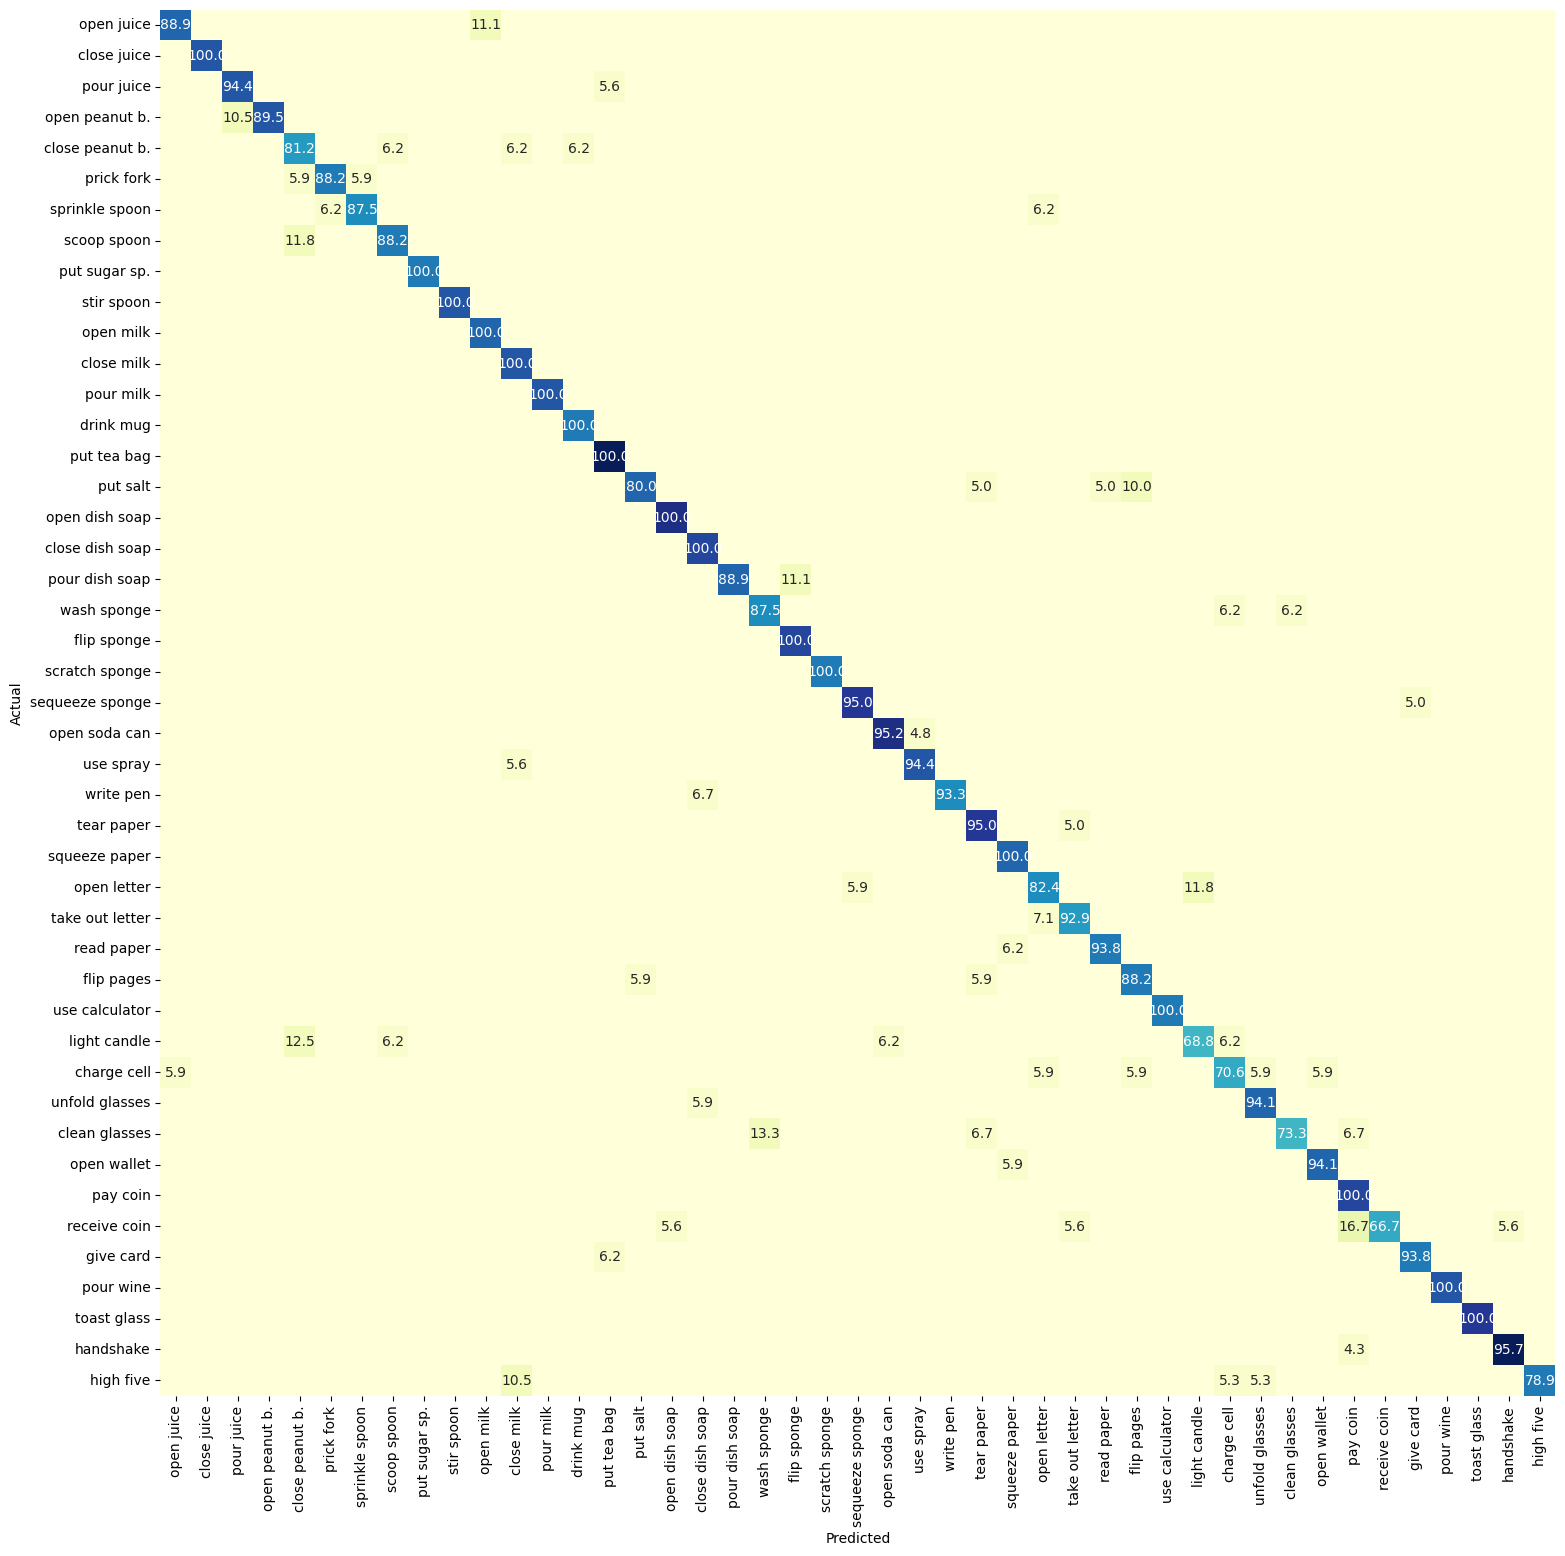

In [43]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test7.png', labels, ymap=None, figsize=(18,18))

### epoch 4

In [44]:
all_rewards,x_trnew_4,policy_net=train(x_trnew_3,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_4))):
    w_p = np.copy(x_trnew_4[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 24%|██████████▏                               | 95/392 [01:07<03:23,  1.46it/s]


 49%|████████████████████                     | 192/392 [02:14<02:18,  1.45it/s]


 74%|██████████████████████████████▏          | 289/392 [03:21<01:16,  1.34it/s]


 98%|████████████████████████████████████████▎| 386/392 [04:27<00:03,  1.51it/s]


100%|████████████████████████████████████████████| 1/1 [04:31<00:00, 271.14s/it]


[-12.25]


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 129.84it/s]


In [45]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 4s 9ms/step - loss: 0.0412 - accuracy: 0.9974 - val_loss: 0.3899 - val_accuracy: 0.9029
Epoch 2/600
392/392 [==============================] - 0s 220us/step - loss: 0.0784 - accuracy: 0.9974 - val_loss: 0.3595 - val_accuracy: 0.9106
Epoch 3/600
392/392 [==============================] - 0s 216us/step - loss: 0.0668 - accuracy: 0.9974 - val_loss: 0.4732 - val_accuracy: 0.8838
Epoch 4/600
392/392 [==============================] - 0s 226us/step - loss: 0.0857 - accuracy: 0.9898 - val_loss: 0.5896 - val_accuracy: 0.8582
Epoch 5/600
392/392 [==============================] - 0s 220us/step - loss: 0.0724 - accuracy: 0.9898 - val_loss: 0.7415 - val_accuracy: 0.8250
Epoch 6/600
392/392 [==============================] - 0s 221us/step - loss: 0.0698 - accuracy: 0.9949 - val_loss: 1.0138 - val_accuracy: 0.7765
Epoch 7/600
392/392 [==============================] - 0s 221us/step - loss: 0.0826 - 

Epoch 57/600
392/392 [==============================] - 0s 260us/step - loss: 0.0485 - accuracy: 0.9974 - val_loss: 0.4270 - val_accuracy: 0.8876
Epoch 58/600
392/392 [==============================] - 0s 254us/step - loss: 0.0370 - accuracy: 0.9974 - val_loss: 0.4244 - val_accuracy: 0.8876
Epoch 59/600
392/392 [==============================] - 0s 289us/step - loss: 0.0340 - accuracy: 0.9974 - val_loss: 0.4218 - val_accuracy: 0.8876
Epoch 60/600
392/392 [==============================] - 0s 247us/step - loss: 0.0382 - accuracy: 0.9974 - val_loss: 0.4190 - val_accuracy: 0.8914
Epoch 61/600
392/392 [==============================] - 0s 251us/step - loss: 0.0476 - accuracy: 0.9974 - val_loss: 0.4162 - val_accuracy: 0.8927
Epoch 62/600
392/392 [==============================] - 0s 242us/step - loss: 0.0458 - accuracy: 0.9949 - val_loss: 0.4134 - val_accuracy: 0.8953
Epoch 63/600
392/392 [==============================] - 0s 240us/step - loss: 0.0317 - accuracy: 0.9949 - val_loss: 0.4111 -

392/392 [==============================] - 0s 243us/step - loss: 0.0370 - accuracy: 0.9974 - val_loss: 0.3522 - val_accuracy: 0.9119
Epoch 114/600
392/392 [==============================] - 0s 253us/step - loss: 0.0374 - accuracy: 0.9949 - val_loss: 0.3516 - val_accuracy: 0.9119
Epoch 115/600
392/392 [==============================] - 0s 248us/step - loss: 0.0489 - accuracy: 0.9974 - val_loss: 0.3511 - val_accuracy: 0.9119
Epoch 116/600
392/392 [==============================] - 0s 248us/step - loss: 0.0482 - accuracy: 0.9974 - val_loss: 0.3506 - val_accuracy: 0.9119
Epoch 117/600
392/392 [==============================] - 0s 241us/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.3502 - val_accuracy: 0.9119
Epoch 118/600
392/392 [==============================] - 0s 247us/step - loss: 0.0351 - accuracy: 0.9974 - val_loss: 0.3497 - val_accuracy: 0.9132
Epoch 119/600
392/392 [==============================] - 0s 239us/step - loss: 0.0434 - accuracy: 1.0000 - val_loss: 0.3492 - val_ac

Epoch 169/600
392/392 [==============================] - 0s 252us/step - loss: 0.0460 - accuracy: 0.9949 - val_loss: 0.3329 - val_accuracy: 0.9170
Epoch 170/600
392/392 [==============================] - 0s 286us/step - loss: 0.0404 - accuracy: 0.9974 - val_loss: 0.3327 - val_accuracy: 0.9170
Epoch 171/600
392/392 [==============================] - 0s 254us/step - loss: 0.0486 - accuracy: 0.9974 - val_loss: 0.3324 - val_accuracy: 0.9170
Epoch 172/600
392/392 [==============================] - 0s 239us/step - loss: 0.0427 - accuracy: 1.0000 - val_loss: 0.3321 - val_accuracy: 0.9170
Epoch 173/600
392/392 [==============================] - 0s 251us/step - loss: 0.0360 - accuracy: 0.9974 - val_loss: 0.3319 - val_accuracy: 0.9170
Epoch 174/600
392/392 [==============================] - 0s 256us/step - loss: 0.0415 - accuracy: 1.0000 - val_loss: 0.3317 - val_accuracy: 0.9170
Epoch 175/600
392/392 [==============================] - 0s 252us/step - loss: 0.0451 - accuracy: 0.9974 - val_loss: 0

Epoch 225/600
392/392 [==============================] - 0s 245us/step - loss: 0.0364 - accuracy: 1.0000 - val_loss: 0.3273 - val_accuracy: 0.9183
Epoch 226/600
392/392 [==============================] - 0s 259us/step - loss: 0.0427 - accuracy: 0.9949 - val_loss: 0.3272 - val_accuracy: 0.9183
Epoch 227/600
392/392 [==============================] - 0s 250us/step - loss: 0.0416 - accuracy: 1.0000 - val_loss: 0.3272 - val_accuracy: 0.9183
Epoch 228/600
392/392 [==============================] - 0s 256us/step - loss: 0.0396 - accuracy: 1.0000 - val_loss: 0.3271 - val_accuracy: 0.9183
Epoch 229/600
392/392 [==============================] - 0s 250us/step - loss: 0.0359 - accuracy: 1.0000 - val_loss: 0.3271 - val_accuracy: 0.9183
Epoch 230/600
392/392 [==============================] - 0s 247us/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.3270 - val_accuracy: 0.9183
Epoch 231/600
392/392 [==============================] - 0s 252us/step - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0

Epoch 281/600
392/392 [==============================] - 0s 266us/step - loss: 0.0366 - accuracy: 0.9974 - val_loss: 0.3260 - val_accuracy: 0.9195
Epoch 282/600
392/392 [==============================] - 0s 242us/step - loss: 0.0481 - accuracy: 0.9974 - val_loss: 0.3260 - val_accuracy: 0.9195
Epoch 283/600
392/392 [==============================] - 0s 254us/step - loss: 0.0387 - accuracy: 1.0000 - val_loss: 0.3260 - val_accuracy: 0.9195
Epoch 284/600
392/392 [==============================] - 0s 248us/step - loss: 0.0446 - accuracy: 0.9974 - val_loss: 0.3262 - val_accuracy: 0.9195
Epoch 285/600
392/392 [==============================] - 0s 241us/step - loss: 0.0428 - accuracy: 0.9974 - val_loss: 0.3262 - val_accuracy: 0.9195
Epoch 286/600
392/392 [==============================] - 0s 248us/step - loss: 0.0407 - accuracy: 0.9974 - val_loss: 0.3263 - val_accuracy: 0.9195
Epoch 287/600
392/392 [==============================] - 0s 241us/step - loss: 0.0372 - accuracy: 0.9974 - val_loss: 0

Epoch 337/600
392/392 [==============================] - 0s 242us/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.3257 - val_accuracy: 0.9208
Epoch 338/600
392/392 [==============================] - 0s 252us/step - loss: 0.0318 - accuracy: 1.0000 - val_loss: 0.3258 - val_accuracy: 0.9208
Epoch 339/600
392/392 [==============================] - 0s 234us/step - loss: 0.0445 - accuracy: 0.9974 - val_loss: 0.3257 - val_accuracy: 0.9208
Epoch 340/600
392/392 [==============================] - 0s 238us/step - loss: 0.0427 - accuracy: 1.0000 - val_loss: 0.3257 - val_accuracy: 0.9208
Epoch 341/600
392/392 [==============================] - 0s 240us/step - loss: 0.0498 - accuracy: 0.9949 - val_loss: 0.3257 - val_accuracy: 0.9208
Epoch 342/600
392/392 [==============================] - 0s 252us/step - loss: 0.0476 - accuracy: 0.9923 - val_loss: 0.3257 - val_accuracy: 0.9208
Epoch 343/600
392/392 [==============================] - 0s 248us/step - loss: 0.0429 - accuracy: 0.9974 - val_loss: 0

Epoch 393/600
392/392 [==============================] - 0s 268us/step - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.3240 - val_accuracy: 0.9195
Epoch 394/600
392/392 [==============================] - 0s 260us/step - loss: 0.0321 - accuracy: 1.0000 - val_loss: 0.3239 - val_accuracy: 0.9195
Epoch 395/600
392/392 [==============================] - 0s 235us/step - loss: 0.0348 - accuracy: 0.9974 - val_loss: 0.3238 - val_accuracy: 0.9195
Epoch 396/600
392/392 [==============================] - 0s 261us/step - loss: 0.0366 - accuracy: 0.9974 - val_loss: 0.3238 - val_accuracy: 0.9195
Epoch 397/600
392/392 [==============================] - 0s 235us/step - loss: 0.0321 - accuracy: 1.0000 - val_loss: 0.3238 - val_accuracy: 0.9195
Epoch 398/600
392/392 [==============================] - 0s 235us/step - loss: 0.0418 - accuracy: 0.9974 - val_loss: 0.3237 - val_accuracy: 0.9195
Epoch 399/600
392/392 [==============================] - 0s 240us/step - loss: 0.0474 - accuracy: 1.0000 - val_loss: 0

Epoch 449/600
392/392 [==============================] - 0s 255us/step - loss: 0.0354 - accuracy: 1.0000 - val_loss: 0.3237 - val_accuracy: 0.9221
Epoch 450/600
392/392 [==============================] - 0s 249us/step - loss: 0.0365 - accuracy: 0.9949 - val_loss: 0.3237 - val_accuracy: 0.9221
Epoch 451/600
392/392 [==============================] - 0s 252us/step - loss: 0.0440 - accuracy: 0.9949 - val_loss: 0.3236 - val_accuracy: 0.9221
Epoch 452/600
392/392 [==============================] - 0s 259us/step - loss: 0.0377 - accuracy: 1.0000 - val_loss: 0.3236 - val_accuracy: 0.9221
Epoch 453/600
392/392 [==============================] - 0s 249us/step - loss: 0.0393 - accuracy: 0.9974 - val_loss: 0.3235 - val_accuracy: 0.9221
Epoch 454/600
392/392 [==============================] - 0s 252us/step - loss: 0.0488 - accuracy: 0.9923 - val_loss: 0.3235 - val_accuracy: 0.9221
Epoch 455/600
392/392 [==============================] - 0s 233us/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0

Epoch 505/600
392/392 [==============================] - 0s 241us/step - loss: 0.0341 - accuracy: 1.0000 - val_loss: 0.3231 - val_accuracy: 0.9234
Epoch 506/600
392/392 [==============================] - 0s 256us/step - loss: 0.0257 - accuracy: 1.0000 - val_loss: 0.3231 - val_accuracy: 0.9234
Epoch 507/600
392/392 [==============================] - 0s 247us/step - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9234
Epoch 508/600
392/392 [==============================] - 0s 248us/step - loss: 0.0322 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9234
Epoch 509/600
392/392 [==============================] - 0s 244us/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9234
Epoch 510/600
392/392 [==============================] - 0s 238us/step - loss: 0.0281 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9234
Epoch 511/600
392/392 [==============================] - 0s 252us/step - loss: 0.0498 - accuracy: 0.9949 - val_loss: 0

Epoch 561/600
392/392 [==============================] - 0s 245us/step - loss: 0.0301 - accuracy: 1.0000 - val_loss: 0.3223 - val_accuracy: 0.9234
Epoch 562/600
392/392 [==============================] - 0s 239us/step - loss: 0.0461 - accuracy: 0.9949 - val_loss: 0.3224 - val_accuracy: 0.9234
Epoch 563/600
392/392 [==============================] - 0s 243us/step - loss: 0.0391 - accuracy: 0.9974 - val_loss: 0.3225 - val_accuracy: 0.9234
Epoch 564/600
392/392 [==============================] - 0s 243us/step - loss: 0.0459 - accuracy: 0.9974 - val_loss: 0.3225 - val_accuracy: 0.9234
Epoch 565/600
392/392 [==============================] - 0s 241us/step - loss: 0.0341 - accuracy: 0.9974 - val_loss: 0.3226 - val_accuracy: 0.9234
Epoch 566/600
392/392 [==============================] - 0s 254us/step - loss: 0.0352 - accuracy: 0.9974 - val_loss: 0.3226 - val_accuracy: 0.9234
Epoch 567/600
392/392 [==============================] - 0s 251us/step - loss: 0.0355 - accuracy: 0.9949 - val_loss: 0

In [46]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9233716475095786


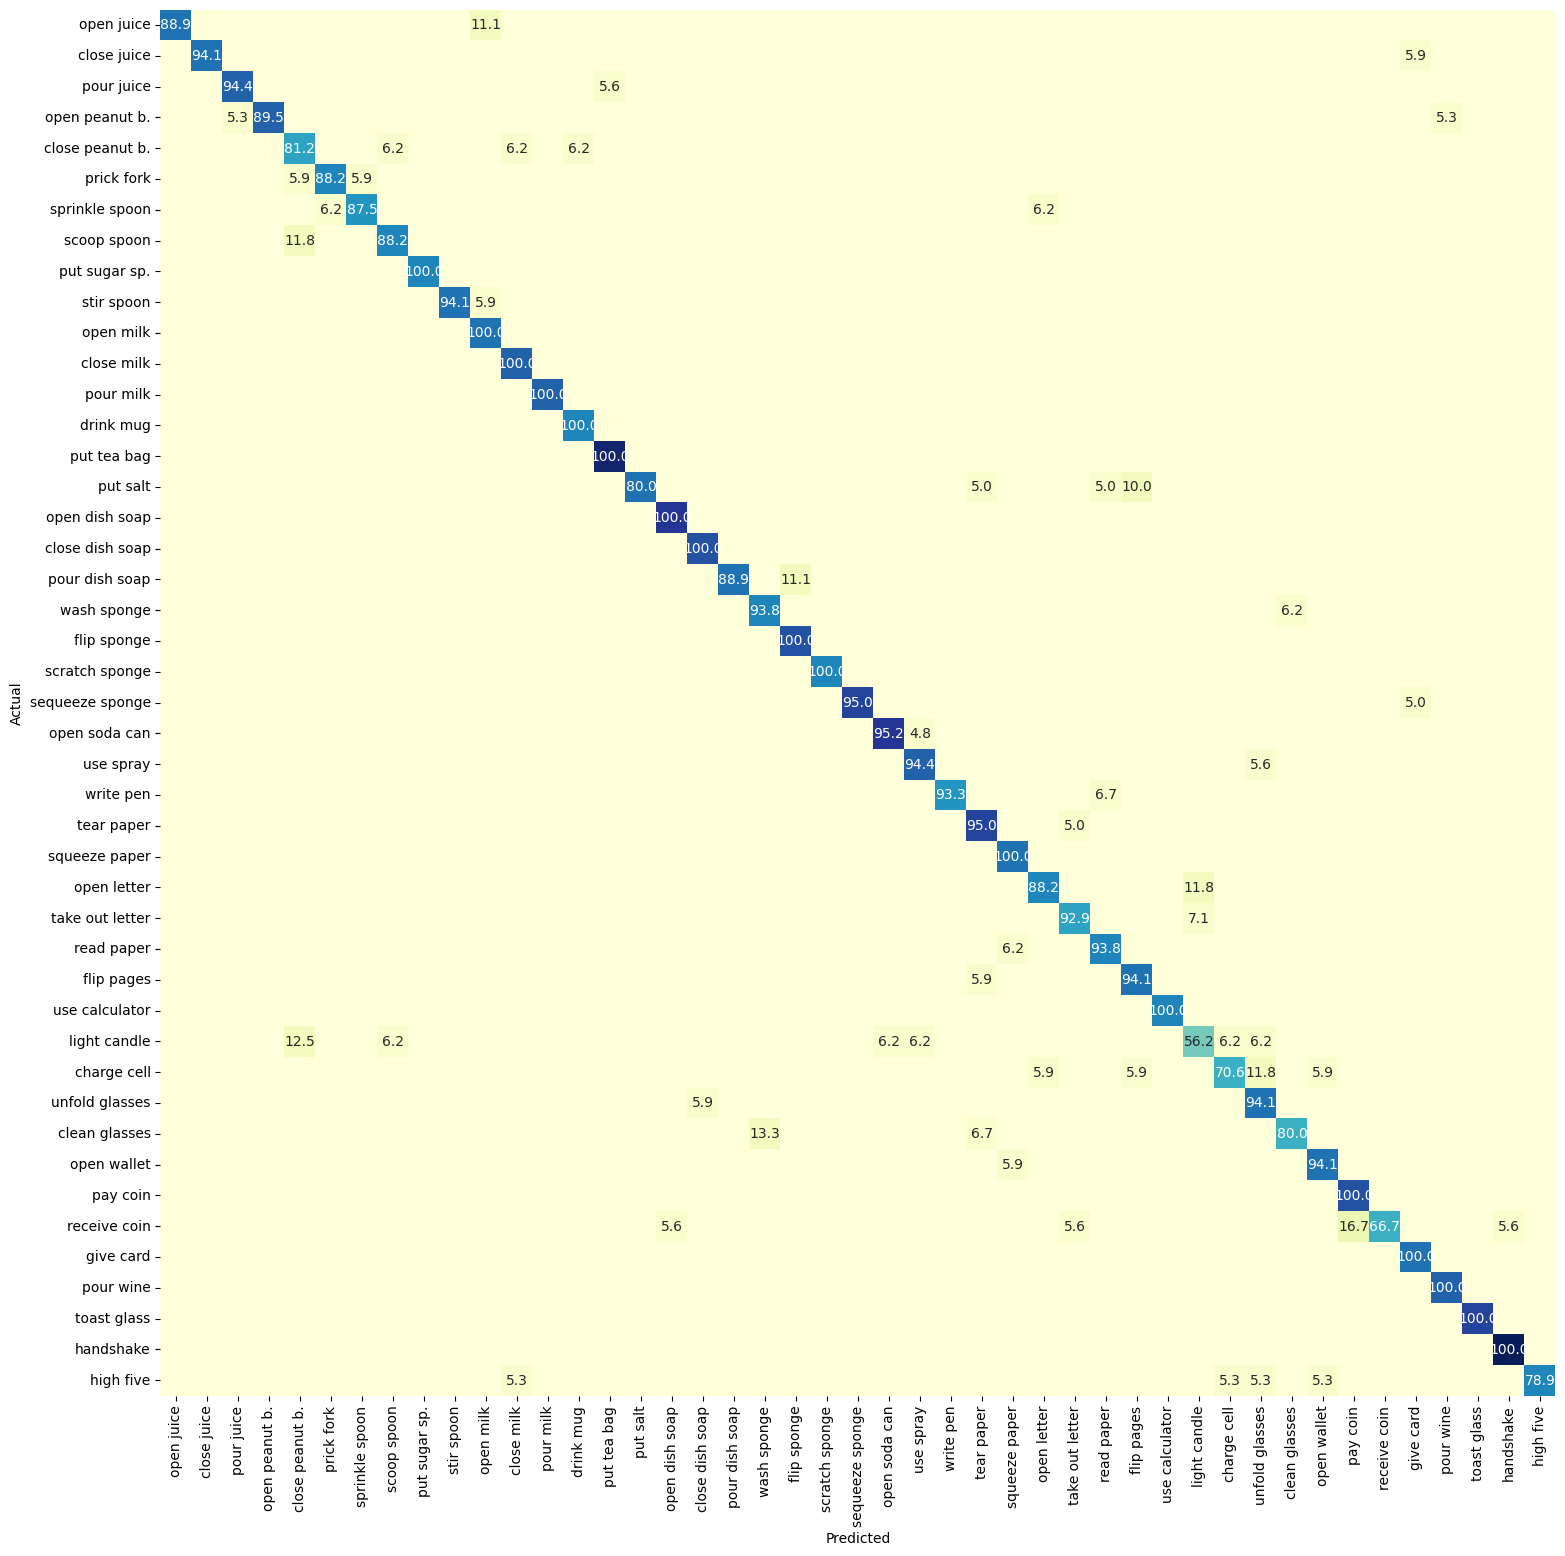

In [47]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test8.png', labels, ymap=None, figsize=(18,18))

### epoch 5

In [48]:
all_rewards,x_trnew_5,policy_net=train(x_trnew_4,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_5))):
    w_p = np.copy(x_trnew_5[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 24%|██████████▏                               | 95/392 [01:05<03:23,  1.46it/s]


 49%|████████████████████                     | 192/392 [02:11<02:22,  1.40it/s]


 74%|██████████████████████████████▏          | 289/392 [03:17<01:11,  1.45it/s]


 98%|████████████████████████████████████████▎| 386/392 [04:24<00:04,  1.42it/s]


100%|████████████████████████████████████████████| 1/1 [04:28<00:00, 268.82s/it]


[-12.25]


100%|████████████████████████████████████████| 392/392 [00:02<00:00, 130.79it/s]


In [49]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 4s 9ms/step - loss: 0.0446 - accuracy: 0.9949 - val_loss: 0.4788 - val_accuracy: 0.8748
Epoch 2/600
392/392 [==============================] - 0s 223us/step - loss: 0.0533 - accuracy: 0.9974 - val_loss: 0.4657 - val_accuracy: 0.8927
Epoch 3/600
392/392 [==============================] - 0s 228us/step - loss: 0.0462 - accuracy: 0.9974 - val_loss: 0.6029 - val_accuracy: 0.8595
Epoch 4/600
392/392 [==============================] - 0s 225us/step - loss: 0.0694 - accuracy: 0.9974 - val_loss: 0.5924 - val_accuracy: 0.8455
Epoch 5/600
392/392 [==============================] - 0s 238us/step - loss: 0.0639 - accuracy: 0.9923 - val_loss: 0.7568 - val_accuracy: 0.8148
Epoch 6/600
392/392 [==============================] - 0s 235us/step - loss: 0.0838 - accuracy: 0.9796 - val_loss: 1.1204 - val_accuracy: 0.7382
Epoch 7/600
392/392 [==============================] - 0s 212us/step - loss: 0.0580 - 

Epoch 57/600
392/392 [==============================] - 0s 250us/step - loss: 0.0338 - accuracy: 0.9923 - val_loss: 0.5172 - val_accuracy: 0.8723
Epoch 58/600
392/392 [==============================] - 0s 259us/step - loss: 0.0485 - accuracy: 0.9923 - val_loss: 0.5132 - val_accuracy: 0.8723
Epoch 59/600
392/392 [==============================] - 0s 258us/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.5094 - val_accuracy: 0.8723
Epoch 60/600
392/392 [==============================] - 0s 259us/step - loss: 0.0300 - accuracy: 1.0000 - val_loss: 0.5056 - val_accuracy: 0.8723
Epoch 61/600
392/392 [==============================] - 0s 246us/step - loss: 0.0354 - accuracy: 0.9974 - val_loss: 0.5016 - val_accuracy: 0.8736
Epoch 62/600
392/392 [==============================] - 0s 250us/step - loss: 0.0310 - accuracy: 1.0000 - val_loss: 0.4980 - val_accuracy: 0.8774
Epoch 63/600
392/392 [==============================] - 0s 254us/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.4946 -

392/392 [==============================] - 0s 263us/step - loss: 0.0425 - accuracy: 0.9923 - val_loss: 0.4054 - val_accuracy: 0.9093
Epoch 114/600
392/392 [==============================] - 0s 280us/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.4044 - val_accuracy: 0.9093
Epoch 115/600
392/392 [==============================] - 0s 276us/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 0.4034 - val_accuracy: 0.9106
Epoch 116/600
392/392 [==============================] - 0s 276us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.4024 - val_accuracy: 0.9106
Epoch 117/600
392/392 [==============================] - 0s 265us/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.4016 - val_accuracy: 0.9119
Epoch 118/600
392/392 [==============================] - 0s 279us/step - loss: 0.0319 - accuracy: 0.9974 - val_loss: 0.4008 - val_accuracy: 0.9119
Epoch 119/600
392/392 [==============================] - 0s 254us/step - loss: 0.0334 - accuracy: 0.9974 - val_loss: 0.4000 - val_ac

Epoch 169/600
392/392 [==============================] - 0s 251us/step - loss: 0.0394 - accuracy: 0.9949 - val_loss: 0.3713 - val_accuracy: 0.9183
Epoch 170/600
392/392 [==============================] - 0s 247us/step - loss: 0.0339 - accuracy: 0.9974 - val_loss: 0.3710 - val_accuracy: 0.9183
Epoch 171/600
392/392 [==============================] - 0s 251us/step - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.3707 - val_accuracy: 0.9183
Epoch 172/600
392/392 [==============================] - 0s 257us/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.3704 - val_accuracy: 0.9183
Epoch 173/600
392/392 [==============================] - 0s 259us/step - loss: 0.0338 - accuracy: 0.9949 - val_loss: 0.3701 - val_accuracy: 0.9183
Epoch 174/600
392/392 [==============================] - 0s 263us/step - loss: 0.0313 - accuracy: 0.9974 - val_loss: 0.3698 - val_accuracy: 0.9183
Epoch 175/600
392/392 [==============================] - 0s 243us/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0

Epoch 225/600
392/392 [==============================] - 0s 254us/step - loss: 0.0287 - accuracy: 0.9974 - val_loss: 0.3597 - val_accuracy: 0.9183
Epoch 226/600
392/392 [==============================] - 0s 252us/step - loss: 0.0251 - accuracy: 1.0000 - val_loss: 0.3596 - val_accuracy: 0.9183
Epoch 227/600
392/392 [==============================] - 0s 253us/step - loss: 0.0248 - accuracy: 0.9974 - val_loss: 0.3594 - val_accuracy: 0.9183
Epoch 228/600
392/392 [==============================] - 0s 275us/step - loss: 0.0356 - accuracy: 0.9949 - val_loss: 0.3593 - val_accuracy: 0.9183
Epoch 229/600
392/392 [==============================] - 0s 250us/step - loss: 0.0371 - accuracy: 0.9974 - val_loss: 0.3592 - val_accuracy: 0.9183
Epoch 230/600
392/392 [==============================] - 0s 243us/step - loss: 0.0342 - accuracy: 0.9949 - val_loss: 0.3592 - val_accuracy: 0.9183
Epoch 231/600
392/392 [==============================] - 0s 251us/step - loss: 0.0316 - accuracy: 0.9974 - val_loss: 0

Epoch 281/600
392/392 [==============================] - 0s 245us/step - loss: 0.0344 - accuracy: 0.9974 - val_loss: 0.3563 - val_accuracy: 0.9221
Epoch 282/600
392/392 [==============================] - 0s 259us/step - loss: 0.0272 - accuracy: 0.9974 - val_loss: 0.3563 - val_accuracy: 0.9221
Epoch 283/600
392/392 [==============================] - 0s 251us/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.3562 - val_accuracy: 0.9221
Epoch 284/600
392/392 [==============================] - 0s 248us/step - loss: 0.0293 - accuracy: 0.9974 - val_loss: 0.3563 - val_accuracy: 0.9221
Epoch 285/600
392/392 [==============================] - 0s 253us/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 0.3563 - val_accuracy: 0.9221
Epoch 286/600
392/392 [==============================] - 0s 247us/step - loss: 0.0341 - accuracy: 0.9974 - val_loss: 0.3563 - val_accuracy: 0.9221
Epoch 287/600
392/392 [==============================] - 0s 251us/step - loss: 0.0355 - accuracy: 0.9949 - val_loss: 0

Epoch 337/600
392/392 [==============================] - 0s 265us/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.3558 - val_accuracy: 0.9221
Epoch 338/600
392/392 [==============================] - 0s 249us/step - loss: 0.0331 - accuracy: 0.9974 - val_loss: 0.3557 - val_accuracy: 0.9221
Epoch 339/600
392/392 [==============================] - 0s 261us/step - loss: 0.0284 - accuracy: 0.9974 - val_loss: 0.3557 - val_accuracy: 0.9195
Epoch 340/600
392/392 [==============================] - 0s 264us/step - loss: 0.0325 - accuracy: 0.9949 - val_loss: 0.3557 - val_accuracy: 0.9208
Epoch 341/600
392/392 [==============================] - 0s 237us/step - loss: 0.0278 - accuracy: 0.9974 - val_loss: 0.3556 - val_accuracy: 0.9208
Epoch 342/600
392/392 [==============================] - 0s 246us/step - loss: 0.0381 - accuracy: 0.9949 - val_loss: 0.3556 - val_accuracy: 0.9208
Epoch 343/600
392/392 [==============================] - 0s 247us/step - loss: 0.0370 - accuracy: 0.9949 - val_loss: 0

Epoch 393/600
392/392 [==============================] - 0s 253us/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.3546 - val_accuracy: 0.9183
Epoch 394/600
392/392 [==============================] - 0s 252us/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.3546 - val_accuracy: 0.9183
Epoch 395/600
392/392 [==============================] - 0s 247us/step - loss: 0.0258 - accuracy: 0.9974 - val_loss: 0.3547 - val_accuracy: 0.9183
Epoch 396/600
392/392 [==============================] - 0s 244us/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.3547 - val_accuracy: 0.9183
Epoch 397/600
392/392 [==============================] - 0s 253us/step - loss: 0.0411 - accuracy: 0.9949 - val_loss: 0.3547 - val_accuracy: 0.9183
Epoch 398/600
392/392 [==============================] - 0s 260us/step - loss: 0.0297 - accuracy: 0.9974 - val_loss: 0.3547 - val_accuracy: 0.9183
Epoch 399/600
392/392 [==============================] - 0s 250us/step - loss: 0.0289 - accuracy: 0.9974 - val_loss: 0

Epoch 449/600
392/392 [==============================] - 0s 257us/step - loss: 0.0240 - accuracy: 1.0000 - val_loss: 0.3525 - val_accuracy: 0.9183
Epoch 450/600
392/392 [==============================] - 0s 261us/step - loss: 0.0389 - accuracy: 0.9974 - val_loss: 0.3525 - val_accuracy: 0.9183
Epoch 451/600
392/392 [==============================] - 0s 247us/step - loss: 0.0391 - accuracy: 0.9974 - val_loss: 0.3525 - val_accuracy: 0.9183
Epoch 452/600
392/392 [==============================] - 0s 255us/step - loss: 0.0331 - accuracy: 0.9974 - val_loss: 0.3525 - val_accuracy: 0.9183
Epoch 453/600
392/392 [==============================] - 0s 235us/step - loss: 0.0428 - accuracy: 0.9974 - val_loss: 0.3525 - val_accuracy: 0.9183
Epoch 454/600
392/392 [==============================] - 0s 244us/step - loss: 0.0287 - accuracy: 1.0000 - val_loss: 0.3525 - val_accuracy: 0.9183
Epoch 455/600
392/392 [==============================] - 0s 267us/step - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0

Epoch 505/600
392/392 [==============================] - 0s 247us/step - loss: 0.0257 - accuracy: 1.0000 - val_loss: 0.3526 - val_accuracy: 0.9195
Epoch 506/600
392/392 [==============================] - 0s 248us/step - loss: 0.0296 - accuracy: 0.9974 - val_loss: 0.3526 - val_accuracy: 0.9195
Epoch 507/600
392/392 [==============================] - 0s 251us/step - loss: 0.0316 - accuracy: 0.9923 - val_loss: 0.3526 - val_accuracy: 0.9195
Epoch 508/600
392/392 [==============================] - 0s 245us/step - loss: 0.0337 - accuracy: 0.9974 - val_loss: 0.3527 - val_accuracy: 0.9195
Epoch 509/600
392/392 [==============================] - 0s 250us/step - loss: 0.0281 - accuracy: 0.9974 - val_loss: 0.3526 - val_accuracy: 0.9195
Epoch 510/600
392/392 [==============================] - 0s 242us/step - loss: 0.0274 - accuracy: 0.9949 - val_loss: 0.3527 - val_accuracy: 0.9195
Epoch 511/600
392/392 [==============================] - 0s 248us/step - loss: 0.0343 - accuracy: 0.9949 - val_loss: 0

Epoch 561/600
392/392 [==============================] - 0s 269us/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 0.3538 - val_accuracy: 0.9195
Epoch 562/600
392/392 [==============================] - 0s 267us/step - loss: 0.0307 - accuracy: 0.9974 - val_loss: 0.3538 - val_accuracy: 0.9195
Epoch 563/600
392/392 [==============================] - 0s 261us/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0.3538 - val_accuracy: 0.9195
Epoch 564/600
392/392 [==============================] - 0s 244us/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 0.3538 - val_accuracy: 0.9195
Epoch 565/600
392/392 [==============================] - 0s 254us/step - loss: 0.0297 - accuracy: 0.9974 - val_loss: 0.3538 - val_accuracy: 0.9195
Epoch 566/600
392/392 [==============================] - 0s 260us/step - loss: 0.0364 - accuracy: 0.9949 - val_loss: 0.3537 - val_accuracy: 0.9183
Epoch 567/600
392/392 [==============================] - 0s 269us/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0

In [50]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9195402298850575


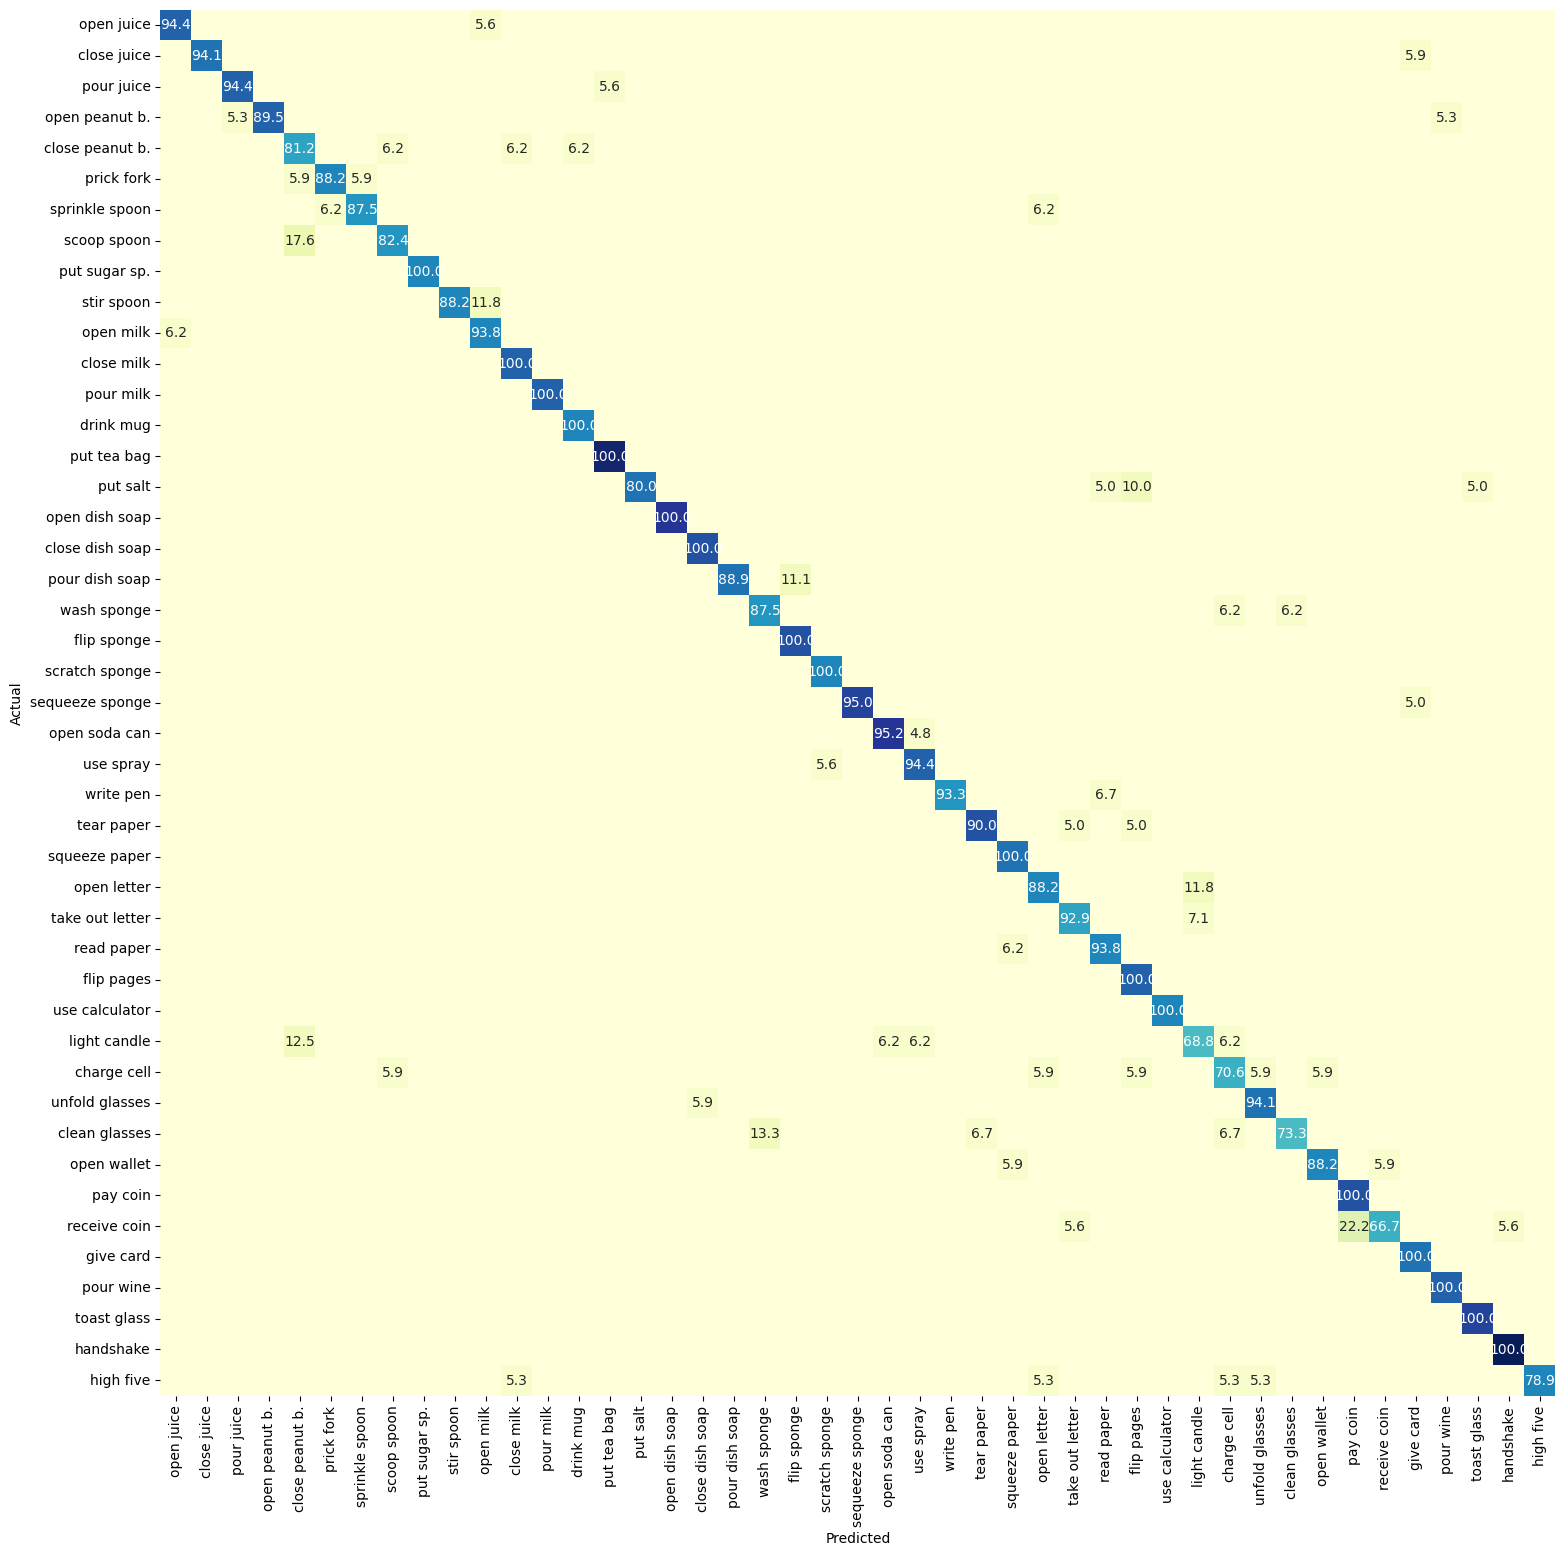

In [51]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test9.png', labels, ymap=None, figsize=(18,18))

In [ ]:
11